# Analyse de corrélation

Nos données contiennent de nombreuses valeurs NaN. Supprimer les colonnes fortement corrélées améliore la rapidité et la robustesse du modèle tout en réduisant le surapprentissage.

## Objectif
Réduire le nombre de colonnes en tenant compte à la fois du nombre de valeurs manquantes et de la corrélation entre colonnes.

## Méthode proposée

1. Regrouper les colonnes par nombre de valeurs manquantes  
    - Exemple : si v1 et v3 ont 56 NaN, v2 en a 21 et v4 en a 5 → groupes : `['v1','v3']`, `['v2']`, `['v4']`.

2. Pour chaque groupe :  
    2.1 Calculer la matrice de corrélation entre les colonnes du groupe.  
         - Ne retenir que les paires dont le coefficient de corrélation (absolu) est ≥ 0,75 (seuil ajustable).

    2.2 Construire des sous-groupes en fusionnant les ensembles de colonnes corrélées (union des ensembles qui se recoupent).  
         - Exemple : `[[v1,v2], [v6], [v1,v4,v2,v5], [v5,v4]]` → fusionner les recouvrements → `[[v1,v2,v4,v5], [v6]]`.

    2.3 Dans chaque sous-groupe, conserver la colonne la plus informative : celle qui a le plus grand nombre de valeurs uniques.  
         - Exemple pour `[v1,v2,v4,v5]` : si `v2` a le plus d’unicité, garder `v2`. Résultat final : `[v2, v6]`.


In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx  # Librairie utile pour gérer les graphes


In [172]:
df_train = pd.read_csv("../Data/train_combined.csv")

In [173]:
def top_missing_cols(df,n=10,thresh=80):
    """
    Renvoie les colonnes manquantes dans le dataframe avec des valeurs manquantes de pourcentage > threesh si n = Aucun. Le dataframe complet sera renvoyé avec des valeurs manquantes de pourcentage > threesh.
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'Il y a {df.isnull().any().sum()} colonnes dans ce jeu de données contenant des valeurs manquantes.')
    print(f'Il y a {dff[dff["missing_percent"] > thresh].shape[0]} colonnes dont le pourcentage de valeurs manquantes est supérieur à {thresh}%.')

    if n:
        return dff.head(n)
    else:
        return dff

In [174]:
df_missing = top_missing_cols(df=df_train,n=None,thresh=50)
missing_cols = df_missing['col']

Il y a 414 colonnes dans ce jeu de données contenant des valeurs manquantes.
Il y a 214 colonnes dont le pourcentage de valeurs manquantes est supérieur à 50%.


In [175]:
# nous allons prendre toutes les colonnes et les regrouper en fonction du pourcentage manquant
nan_dict = {}
for col in missing_cols:
    count = df_train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'Nombre de NAN = {k} pourcentage: {(int(k)/df_train.shape[0])*100} %')
    print(v)

####################
Nombre de NAN = 585793 pourcentage: 99.19615944728554 %
['id_24']
####################
Nombre de NAN = 585408 pourcentage: 99.13096487960172 %
['id_25']
####################
Nombre de NAN = 585385 pourcentage: 99.12707013919464 %
['id_07', 'id_08']
####################
Nombre de NAN = 585381 pourcentage: 99.12639279303687 %
['id_21']
####################
Nombre de NAN = 585377 pourcentage: 99.12571544687913 %
['id_26']
####################
Nombre de NAN = 585371 pourcentage: 99.1246994276425 %
['id_22', 'id_27', 'id_23']
####################
Nombre de NAN = 552913 pourcentage: 93.62837403054831 %
['dist2']
####################
Nombre de NAN = 551623 pourcentage: 93.40992989467267 %
['D7']
####################
Nombre de NAN = 545427 pourcentage: 92.36072069631184 %
['id_18']
####################
Nombre de NAN = 528588 pourcentage: 89.50926270870728 %
['D13']
####################
Nombre de NAN = 528353 pourcentage: 89.46946862193924 %
['D14']
####################
Nom

In [176]:
def correlation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = df_train[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()



In [177]:
def reduce_groups(grps):
    '''
    déterminer la colonne qui a le plus de valeurs uniques parmi un groupe d'attributs
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

## Analyse de corrélation sur les colonnes V

## Groupe1 [V1 à V11]

In [178]:
def group_correlated_columns(df, cols, threshold=0.75):
    """
    Regroupe les colonnes corrélées entre elles selon un seuil donné (en gérant les chevauchements).
    """
    df_sub = df[cols]
    corr_matrix = df_sub.corr().abs()  # Valeurs absolues (corrélation + ou -)
    
    # Crée un graphe vide
    G = nx.Graph()
    
    # Ajoute les colonnes comme noeuds
    G.add_nodes_from(corr_matrix.columns)
    
    # Ajoute une arête entre deux colonnes si leur corrélation dépasse le seuil
    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            if i != j and corr_matrix.loc[i, j] >= threshold:
                G.add_edge(i, j)
    
    # Chaque composante connexe du graphe = un groupe de colonnes corrélées
    groups = [list(comp) for comp in nx.connected_components(G)]
    
    # On trie chaque sous-liste pour la lisibilité
    groups = [sorted(g) for g in groups]
    return sorted(groups, key=lambda x: x[0])


In [179]:
reduced_cols = []

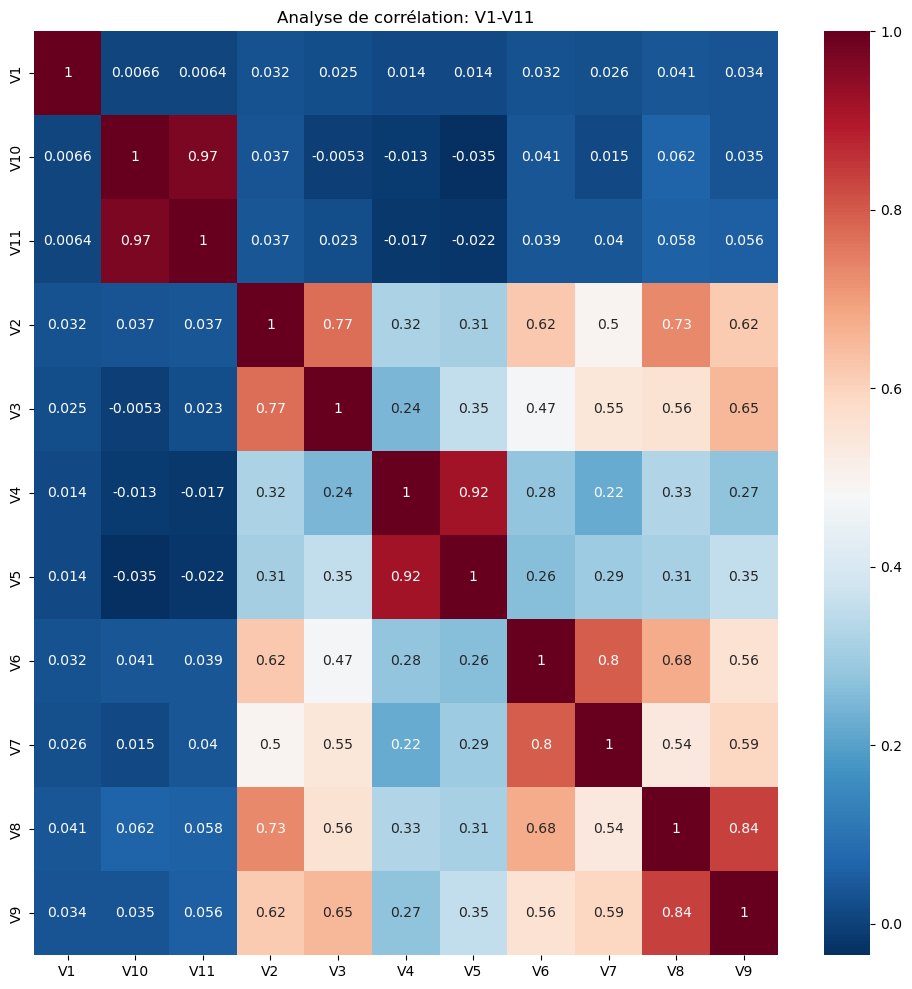

In [180]:
cols = [f"V{i}" for i in range(1, 12)]
correlation_analysis(cols, title="Analyse de corrélation: V1-V11", size=(12,12))

In [181]:
pairs = group_correlated_columns(df_train, cols, threshold=0.75)
cols_reduced_v1_to_v11 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v1_to_v11)
cols_reduced_v1_to_v11

['V1', 'V11', 'V3', 'V4', 'V6', 'V8']

## Groupe2 [V12 - V34]

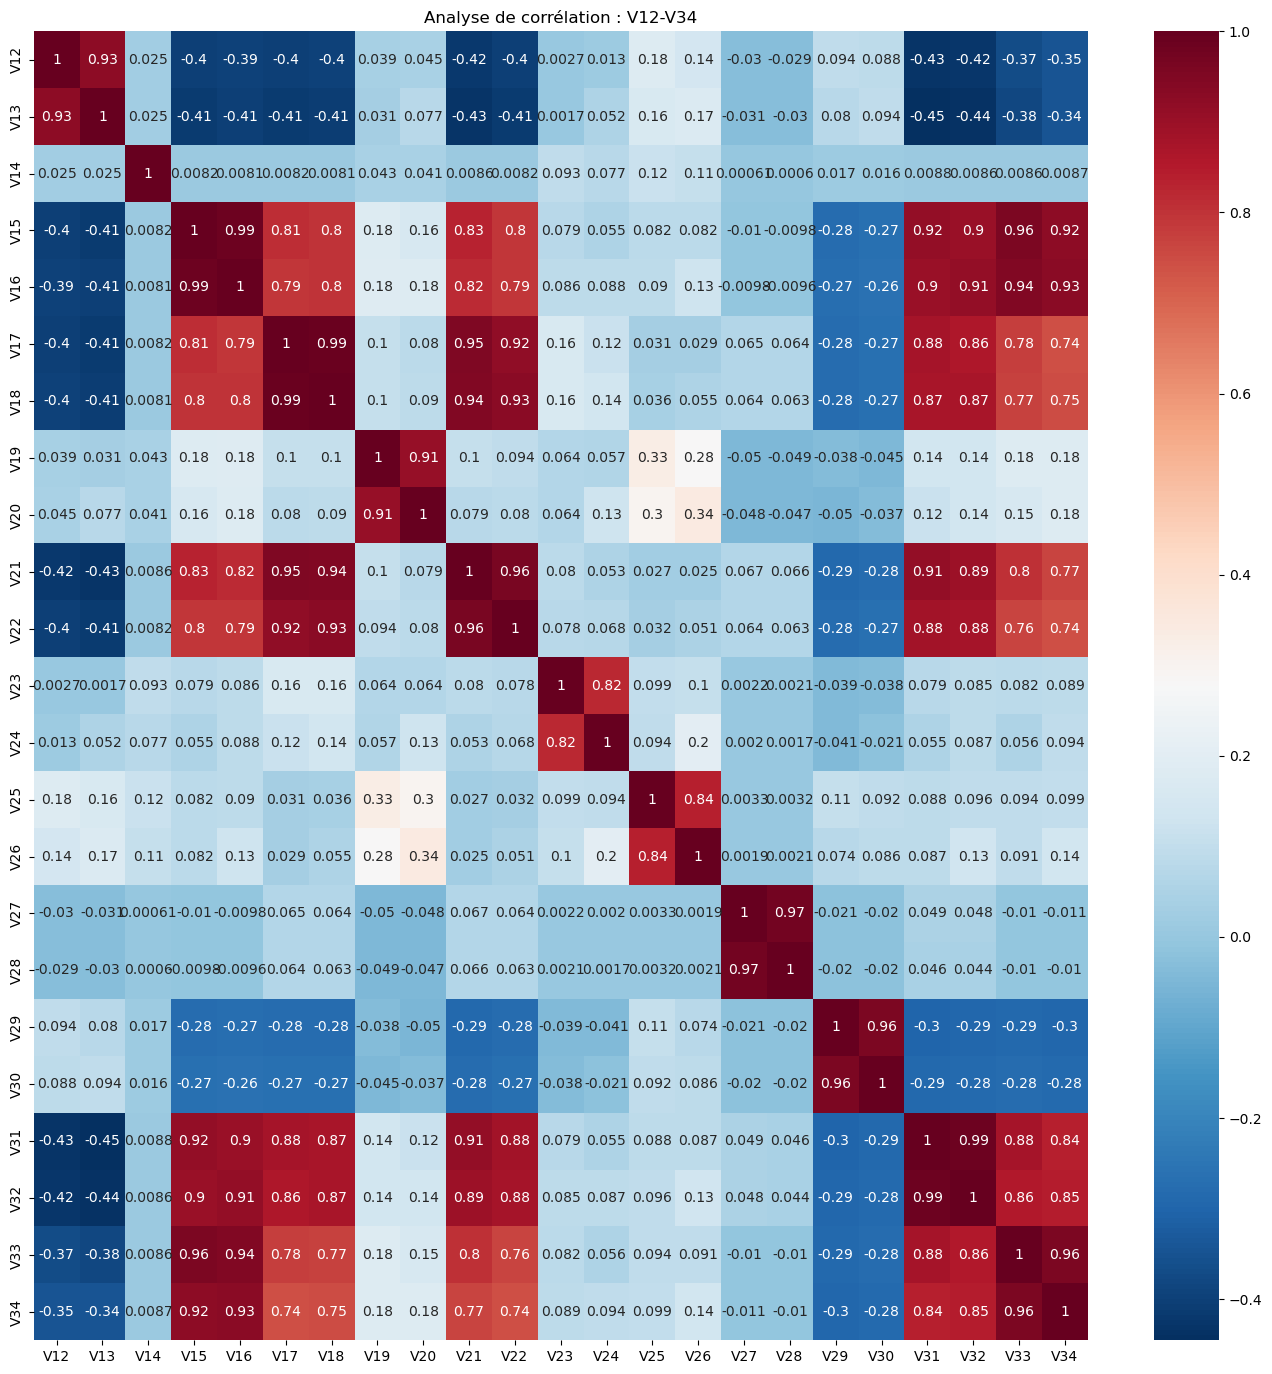

In [182]:
cols = [f"V{i}" for i in range(12, 35)]
correlation_analysis(cols, title="Analyse de corrélation : V12-V34", size=(17,17))

In [183]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v12_to_v34 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v12_to_v34)
cols_reduced_v12_to_v34

['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']

## Groupe3 [V35 - V52]

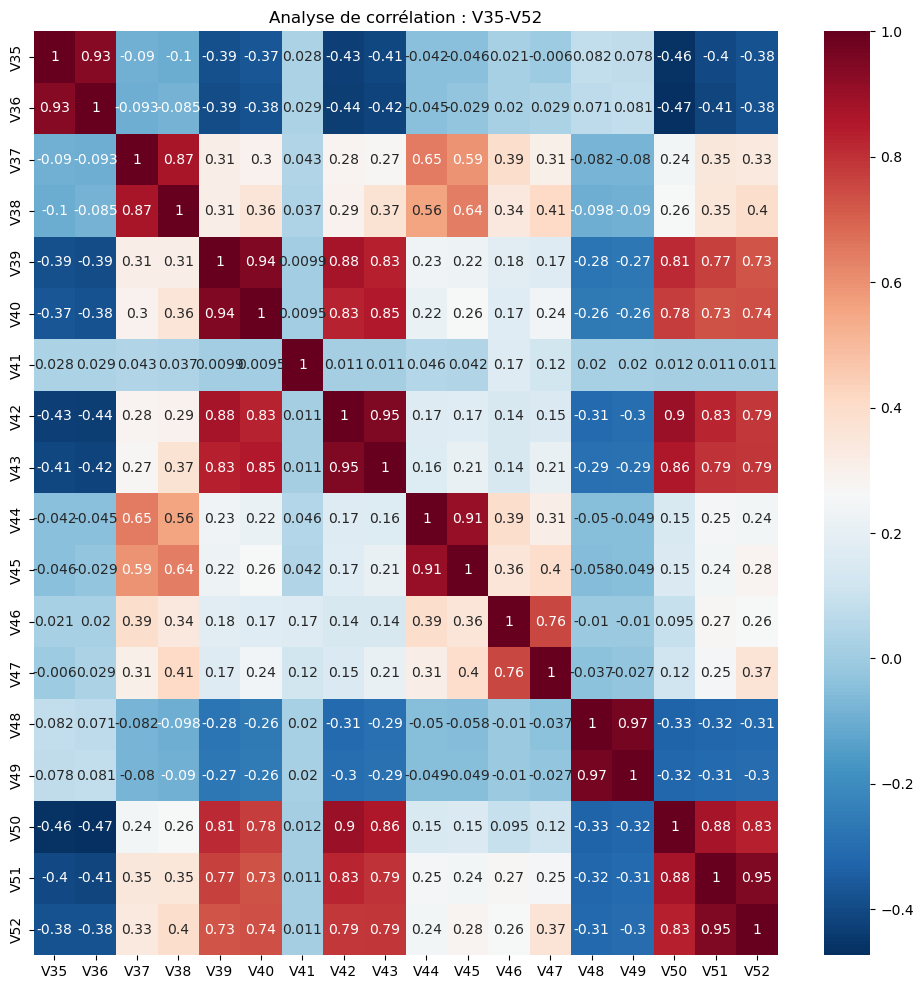

In [184]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42',
 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']
correlation_analysis(cols, title="Analyse de corrélation : V35-V52", size=(12,12))

In [185]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v35_to_v52 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v35_to_v52)
cols_reduced_v35_to_v52

['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48']

## Groupe4 [V52 - V74]

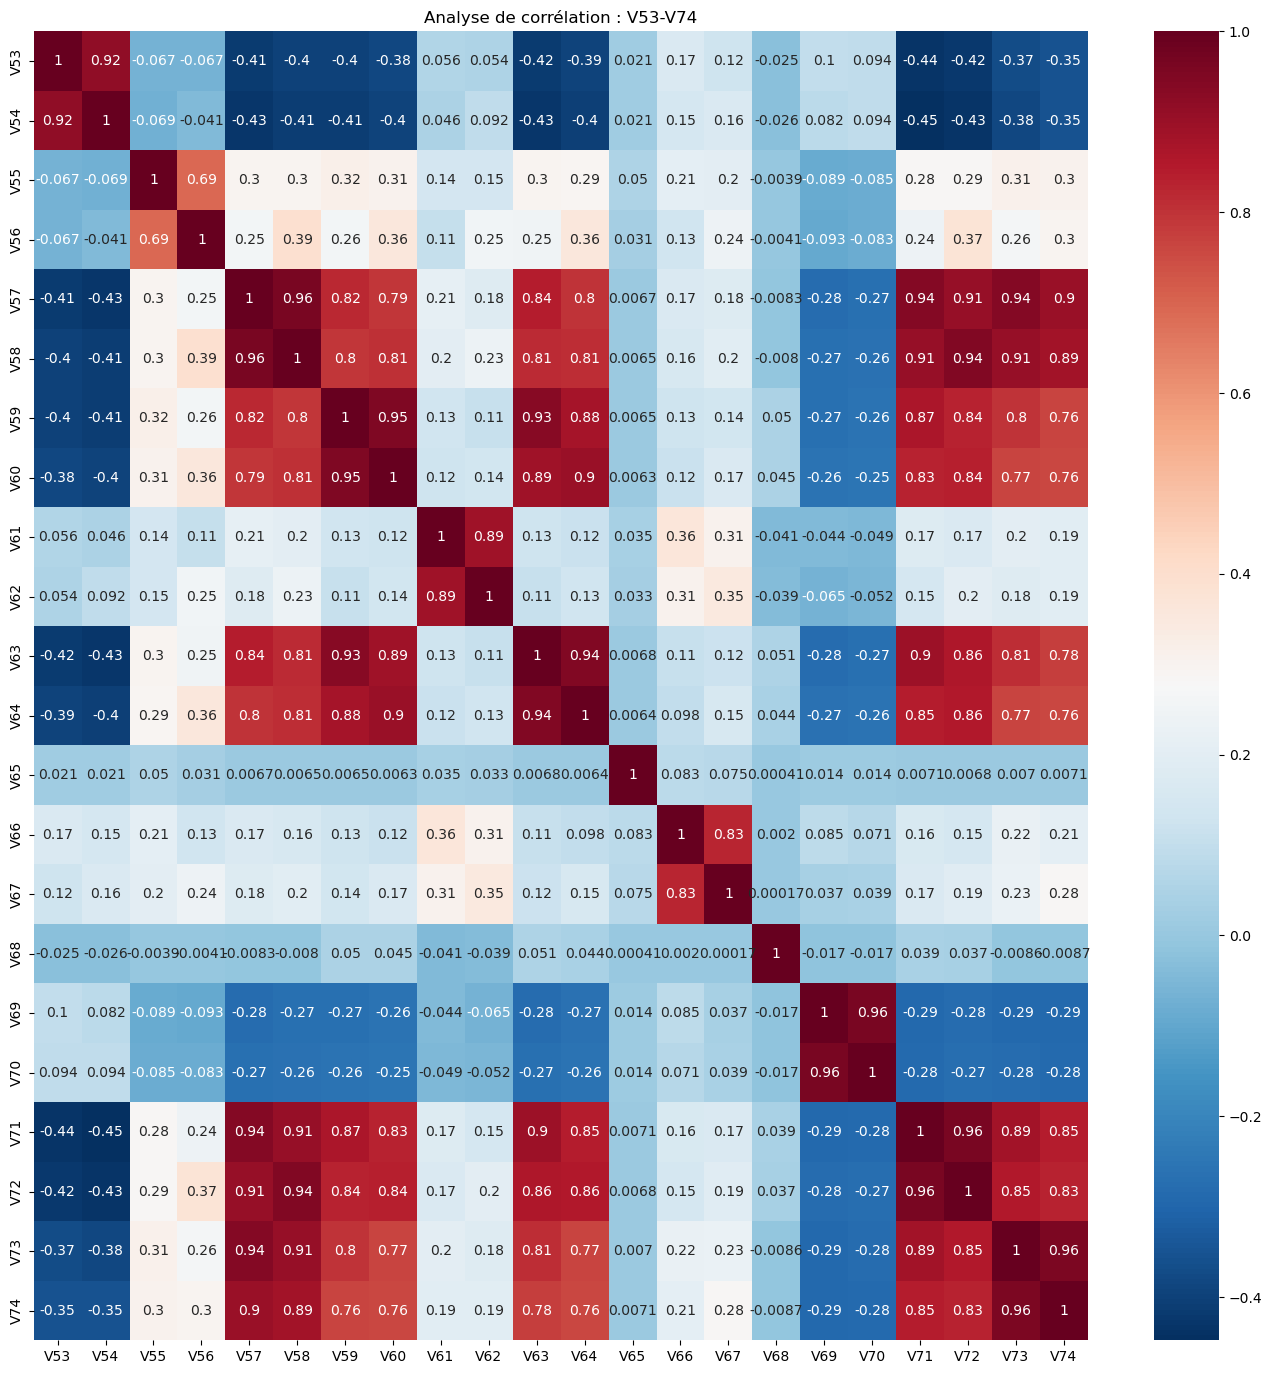

In [186]:
cols = ['V72', 'V74', 'V73', 'V71', 'V65', 'V68', 'V58', 'V70', 'V53', 
 'V54', 'V55', 'V56', 'V57', 'V59', 'V67', 'V60', 'V61',
 'V62', 'V63', 'V64', 'V66', 'V69']
correlation_analysis(cols, title="Analyse de corrélation : V53-V74", size=(17,17))

In [187]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v53_to_v74 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v53_to_v74)
cols_reduced_v53_to_v74

['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']

## Groupe5 [V75 - V94]

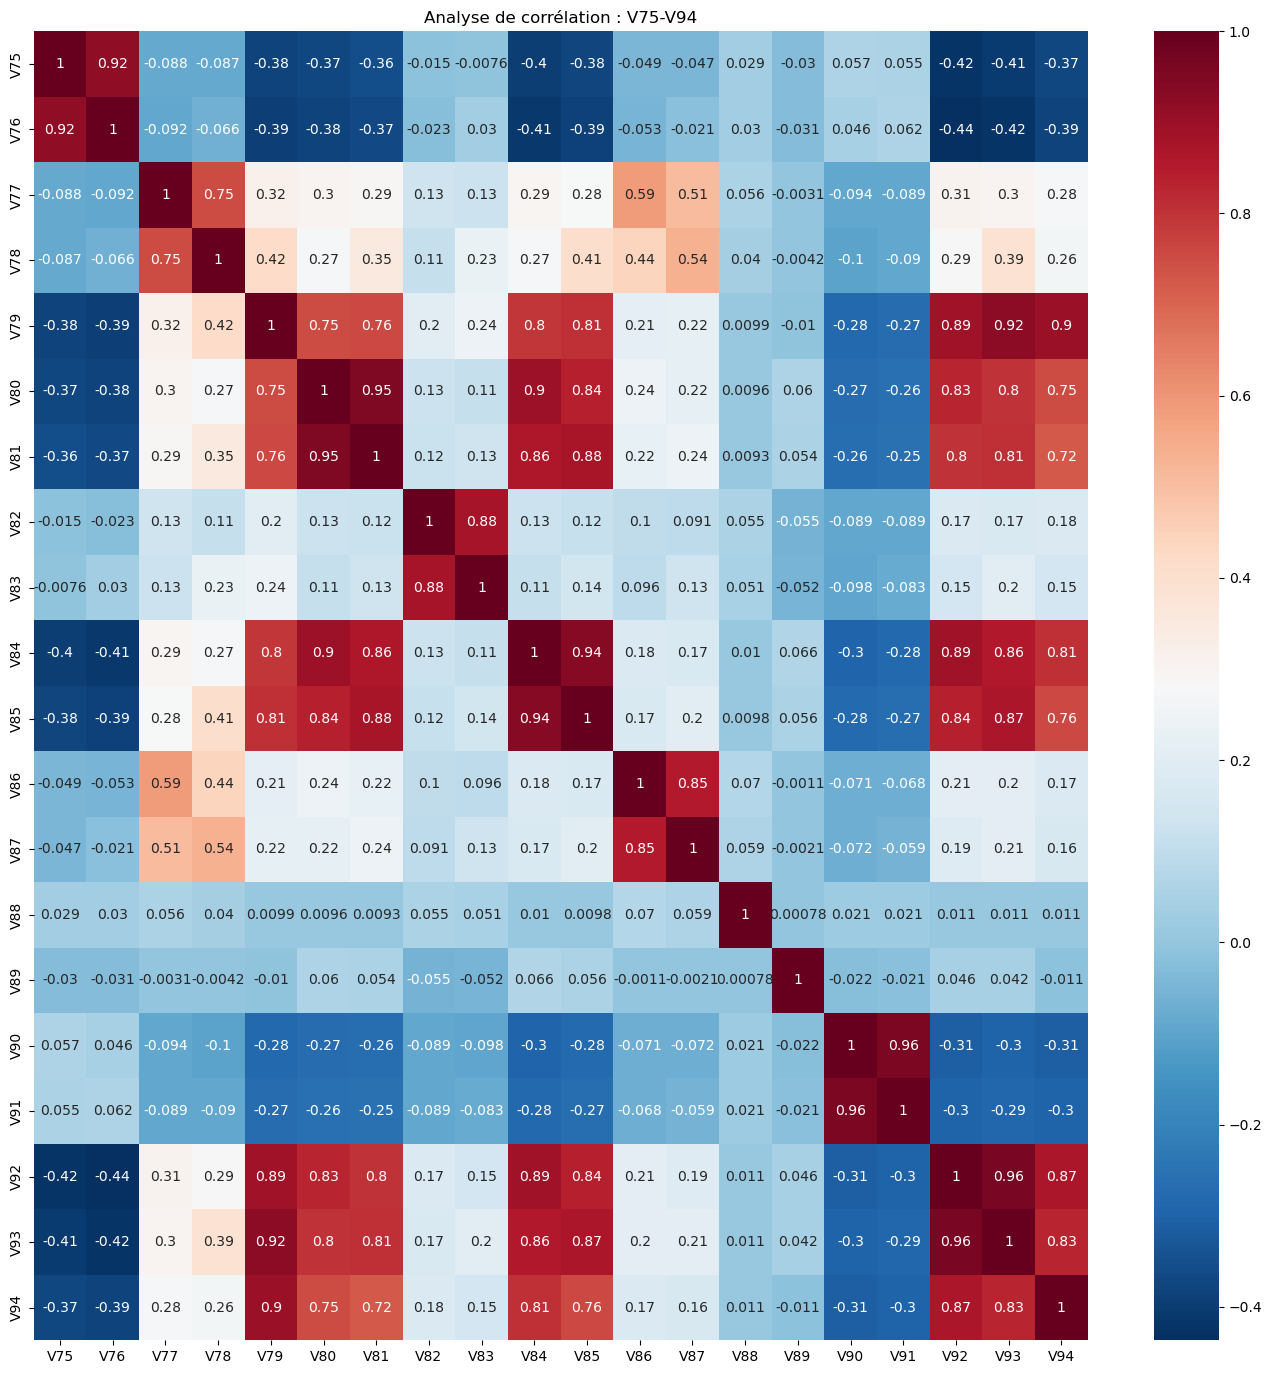

In [188]:
cols = ['V80', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V86', 'V79',
 'V85', 'V75', 'V84', 'V77', 'V83', 'V78', 'V82', 'V81', 'V76']
correlation_analysis(cols, title="Analyse de corrélation : V75-V94", size=(17,17))

In [189]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v75_to_v94 = reduce_groups(pairs)  
reduced_cols.extend(cols_reduced_v75_to_v94)
cols_reduced_v75_to_v94

['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']

## Groupe6 [V95 - V137]

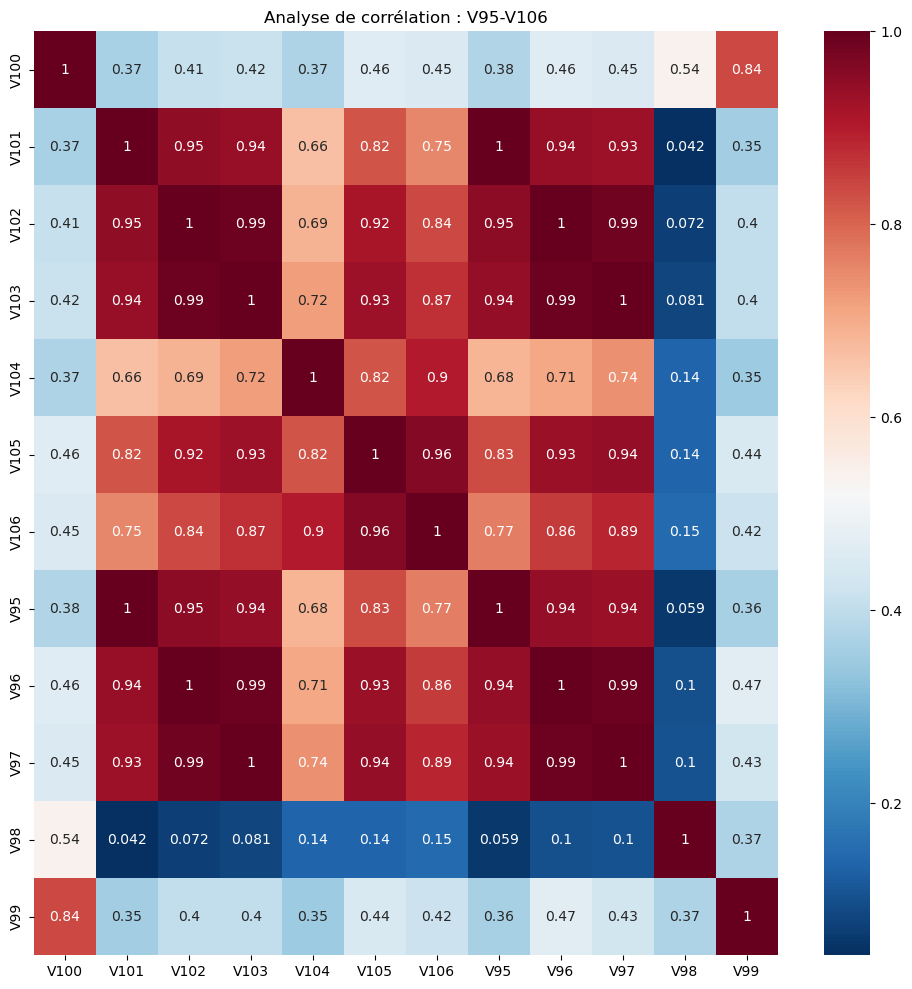

In [190]:
cols = ['V'+str(x) for x in range(95,107)]
correlation_analysis(cols, title="Analyse de corrélation : V95-V106", size=(12,12))

In [191]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v95_to_v107 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v95_to_v107)
cols_reduced_v95_to_v107
# pairs

['V99', 'V96', 'V98']

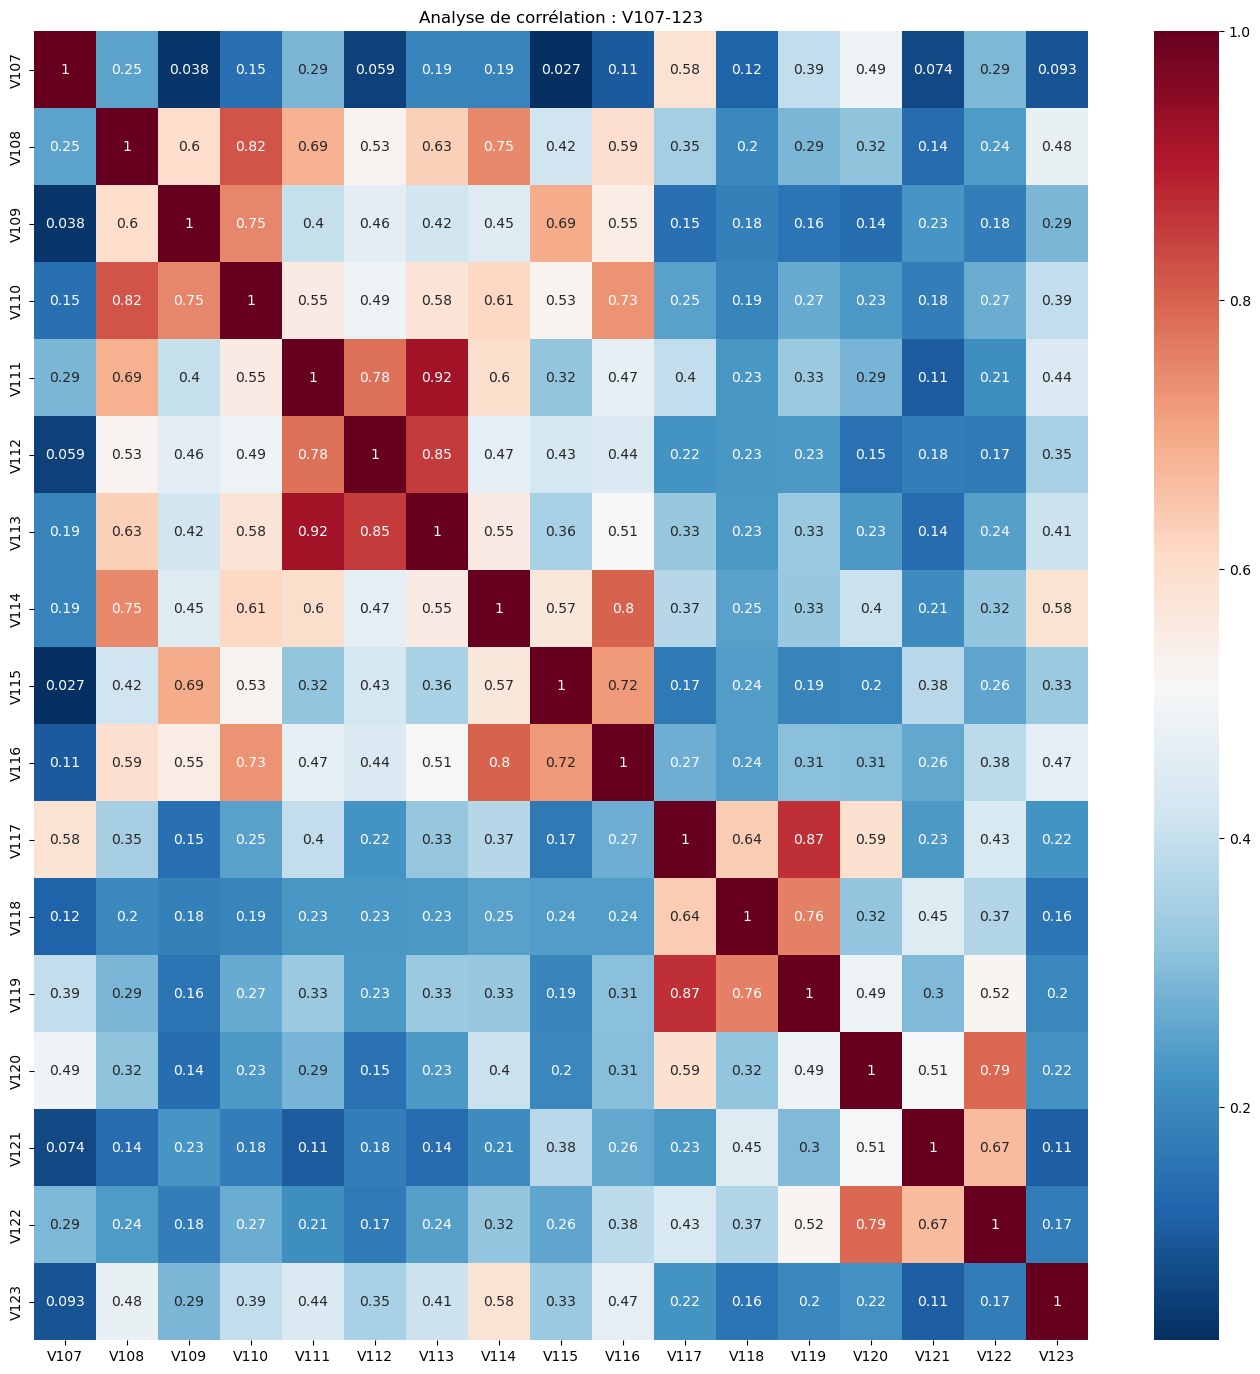

In [192]:
cols = [f"V{i}" for i in range(107, 124)]
correlation_analysis(cols, title="Analyse de corrélation : V107-123", size=(17, 17))

In [193]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v107_to_v123 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v107_to_v123)
cols_reduced_v107_to_v123

['V107',
 'V108',
 'V109',
 'V111',
 'V114',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123']

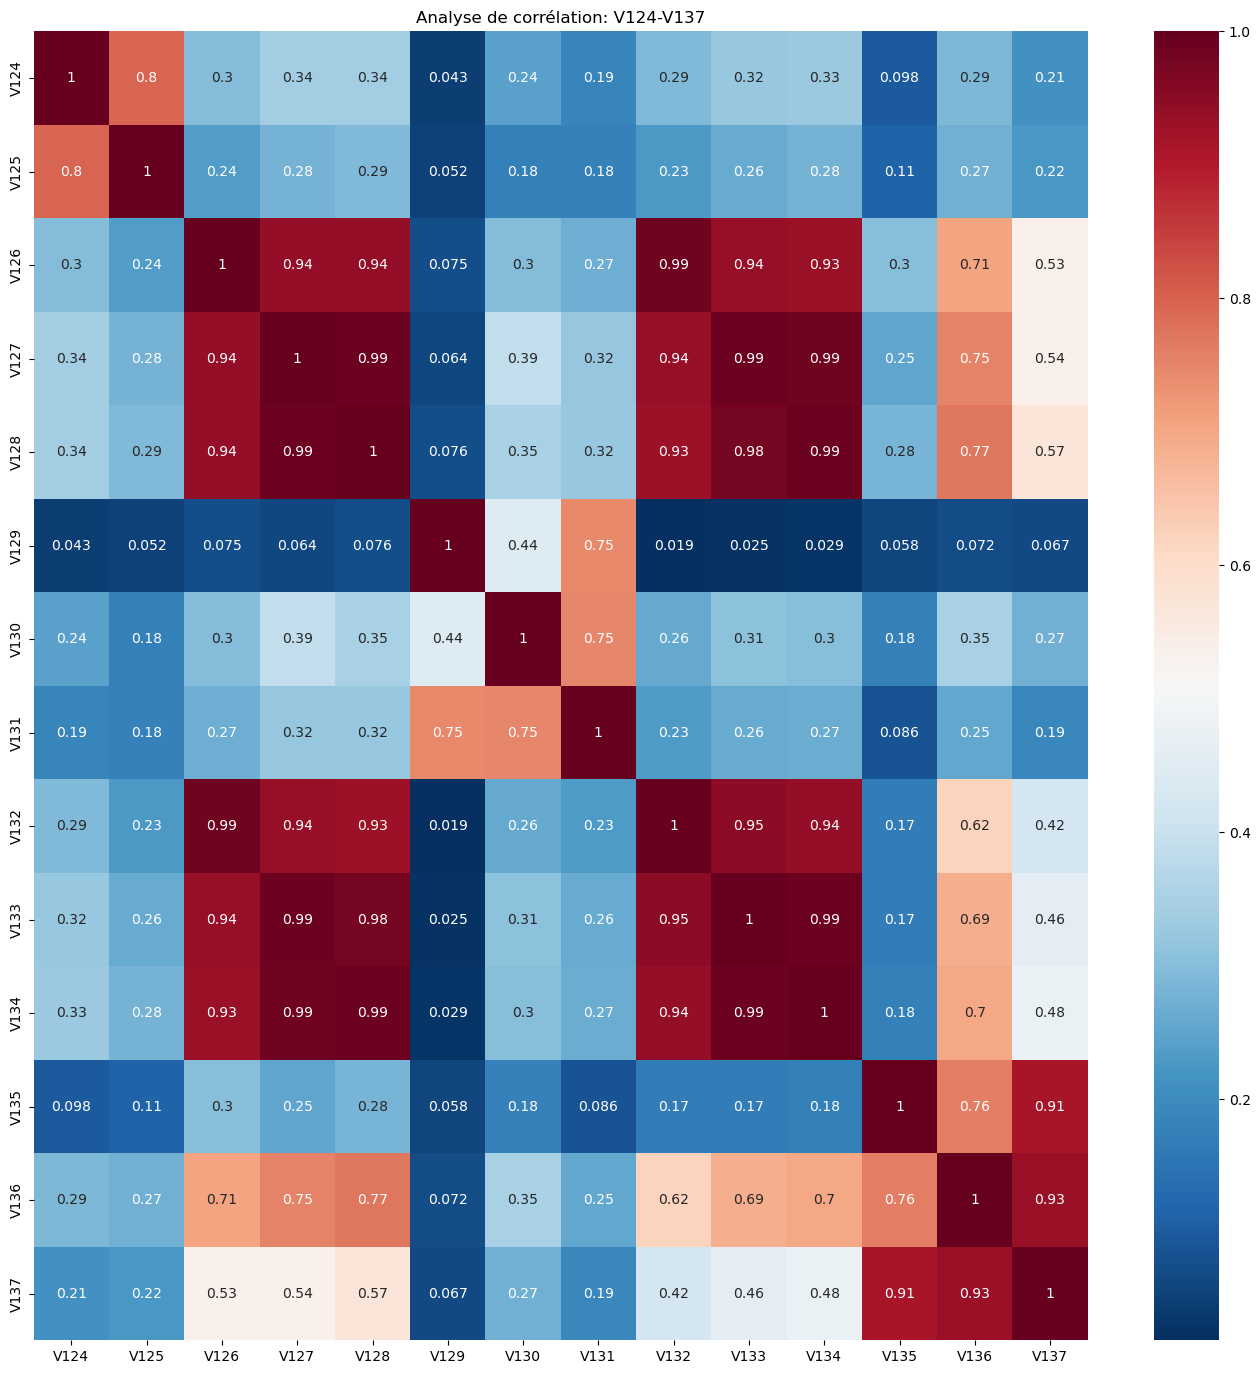

In [194]:
cols = ['V'+str(x) for x in range(124,138)]
coorelation_analysis(cols,title='Analyse de corrélation: V124-V137',size=(17,17))

In [195]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v124_to_v137 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v124_to_v137)
cols_reduced_v124_to_v137

['V124', 'V127', 'V129', 'V130', 'V131']

## Groupe7 [V138 - V163]

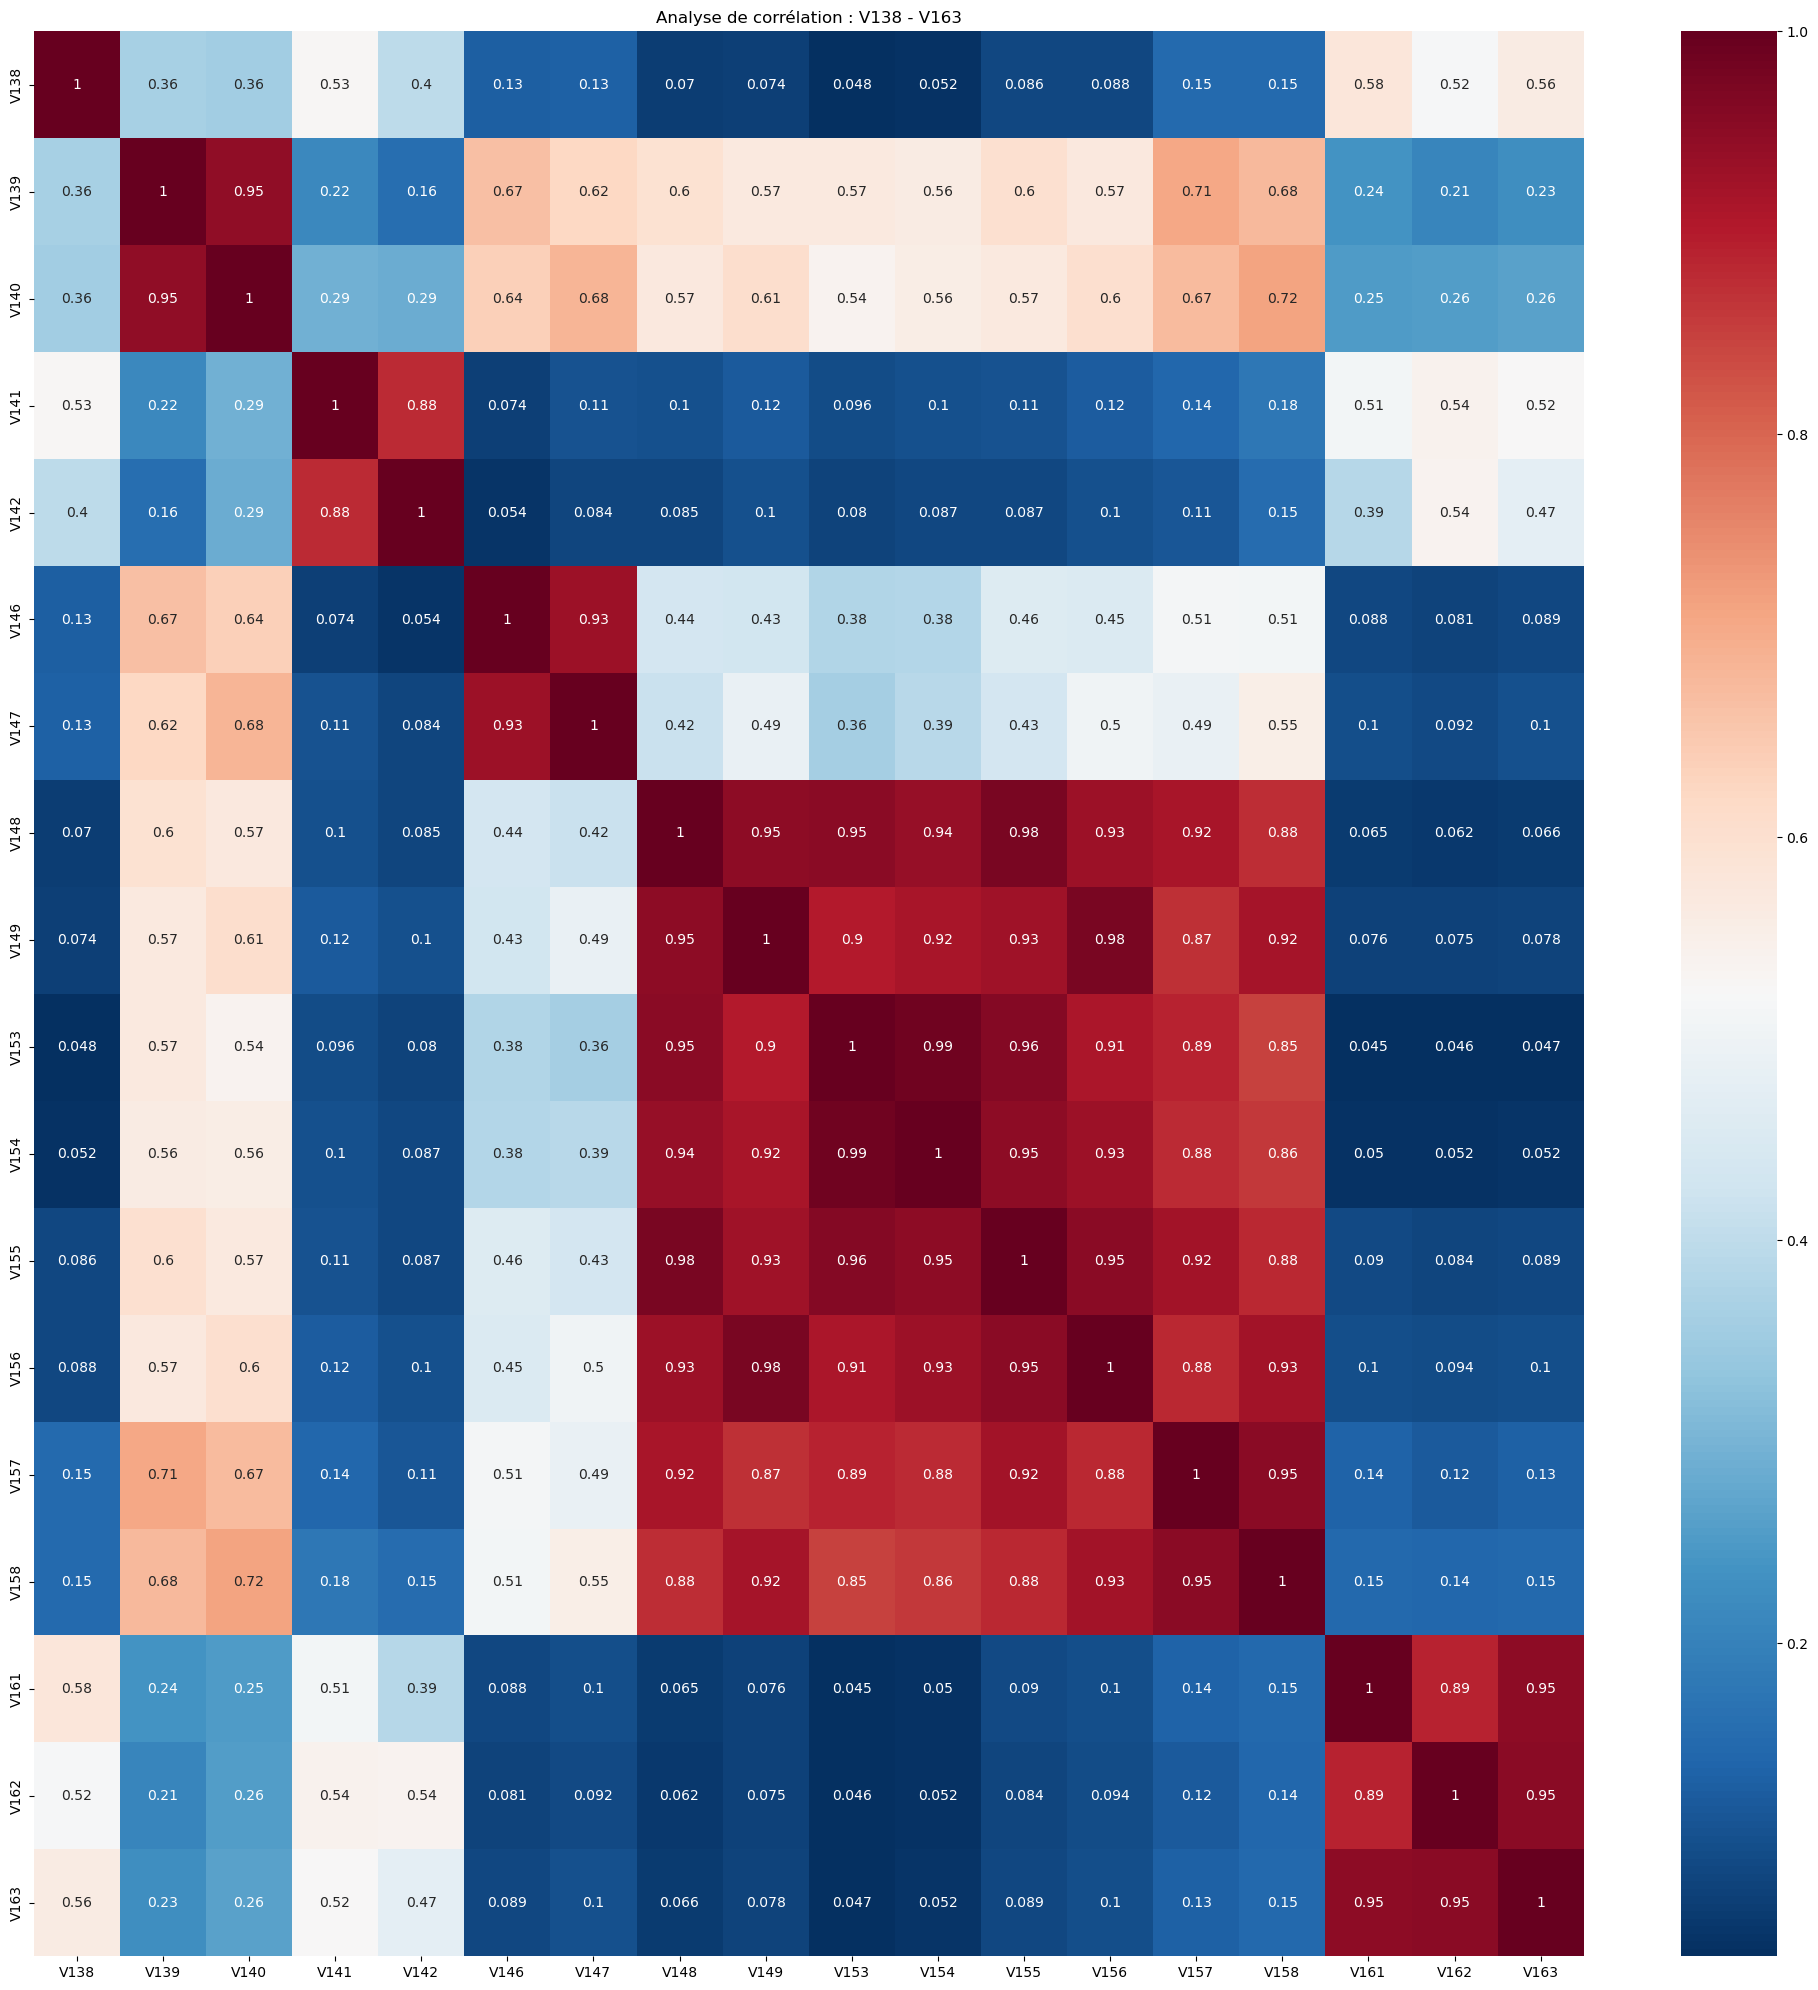

In [196]:
cols = ['V142', 'V158', 'V140', 'V162', 'V141', 'V161', 'V157', 'V146', 'V156', 'V155', 'V154',
        'V153', 'V149', 'V147', 'V148', 'V163', 'V139', 'V138']
coorelation_analysis(cols, title="Analyse de corrélation : V138 - V163", size=(25,25))

In [197]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v138_to_v163 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v138_to_v163)
cols_reduced_v138_to_v163

['V138', 'V139', 'V142', 'V147', 'V155', 'V162']

## Groupe8 [V143 - V166]

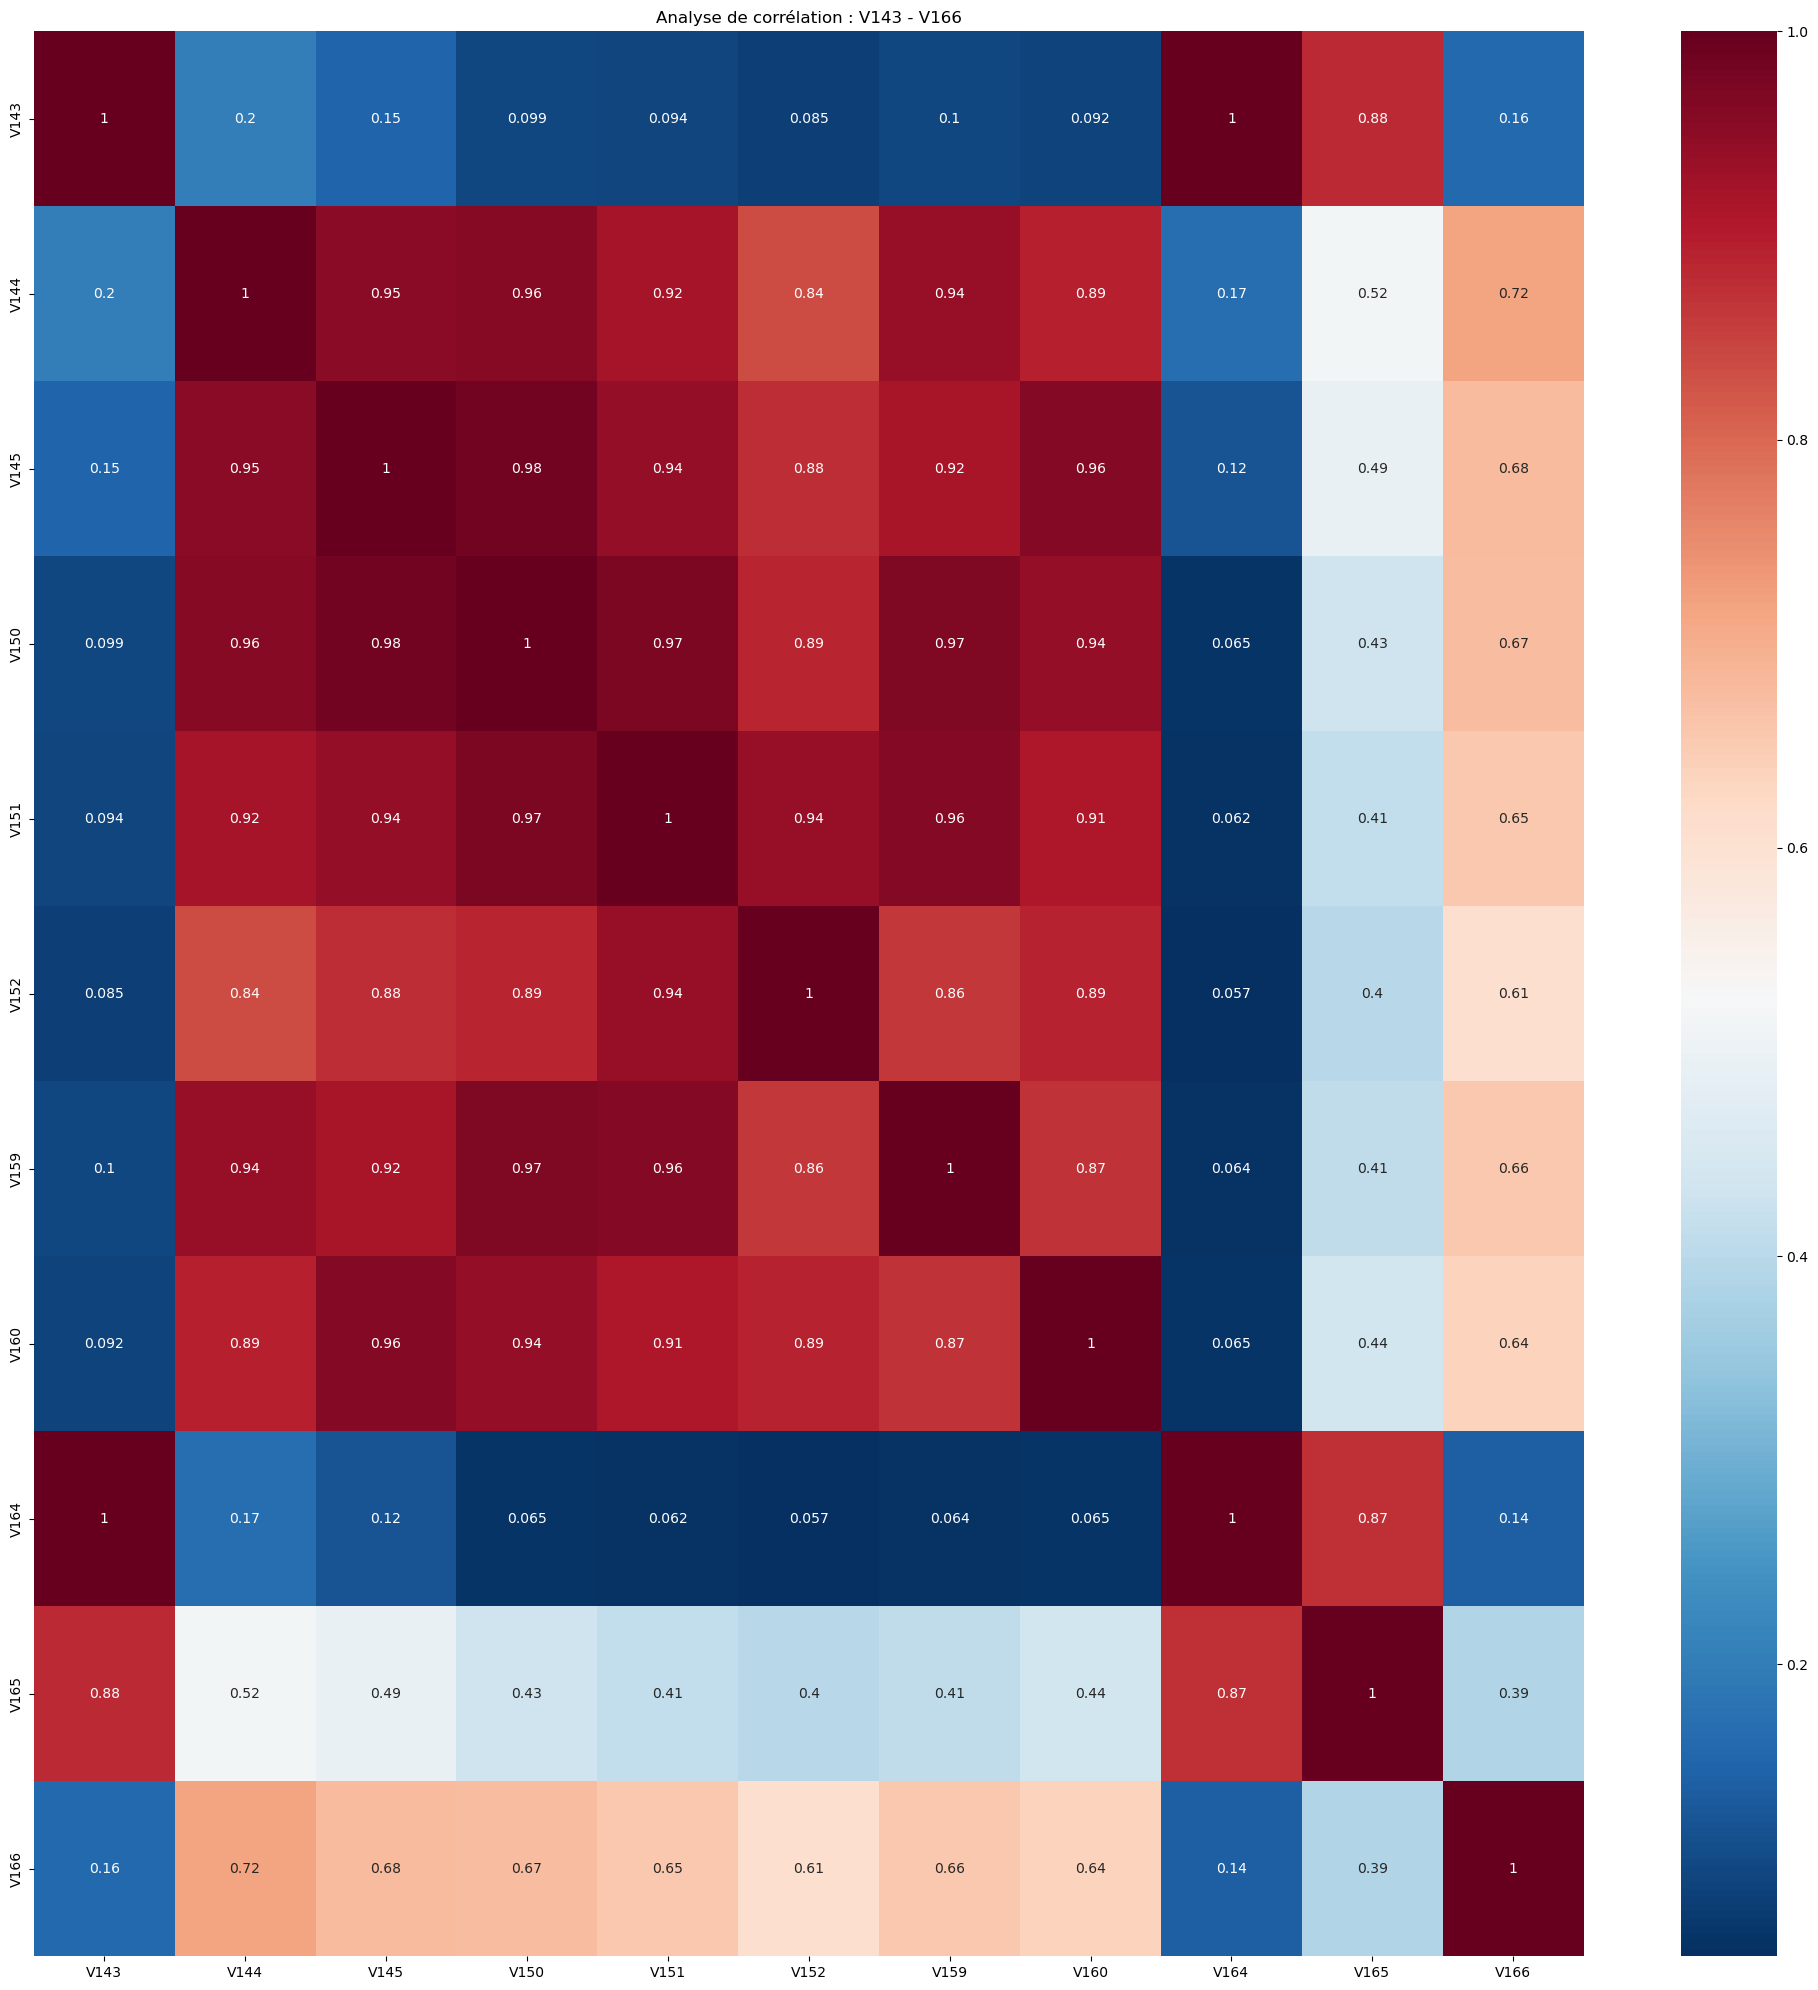

In [198]:
cols = ['V160', 'V151', 'V152', 'V145', 'V144', 'V143', 'V159', 'V164', 'V165', 'V166', 'V150']
correlation_analysis(cols, title="Analyse de corrélation : V143 - V166", size=(25, 25))

In [199]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v143_to_v166 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v143_to_v166)
cols_reduced_v143_to_v166

['V165', 'V160', 'V166']

## Groupe9 [V167 - V216]

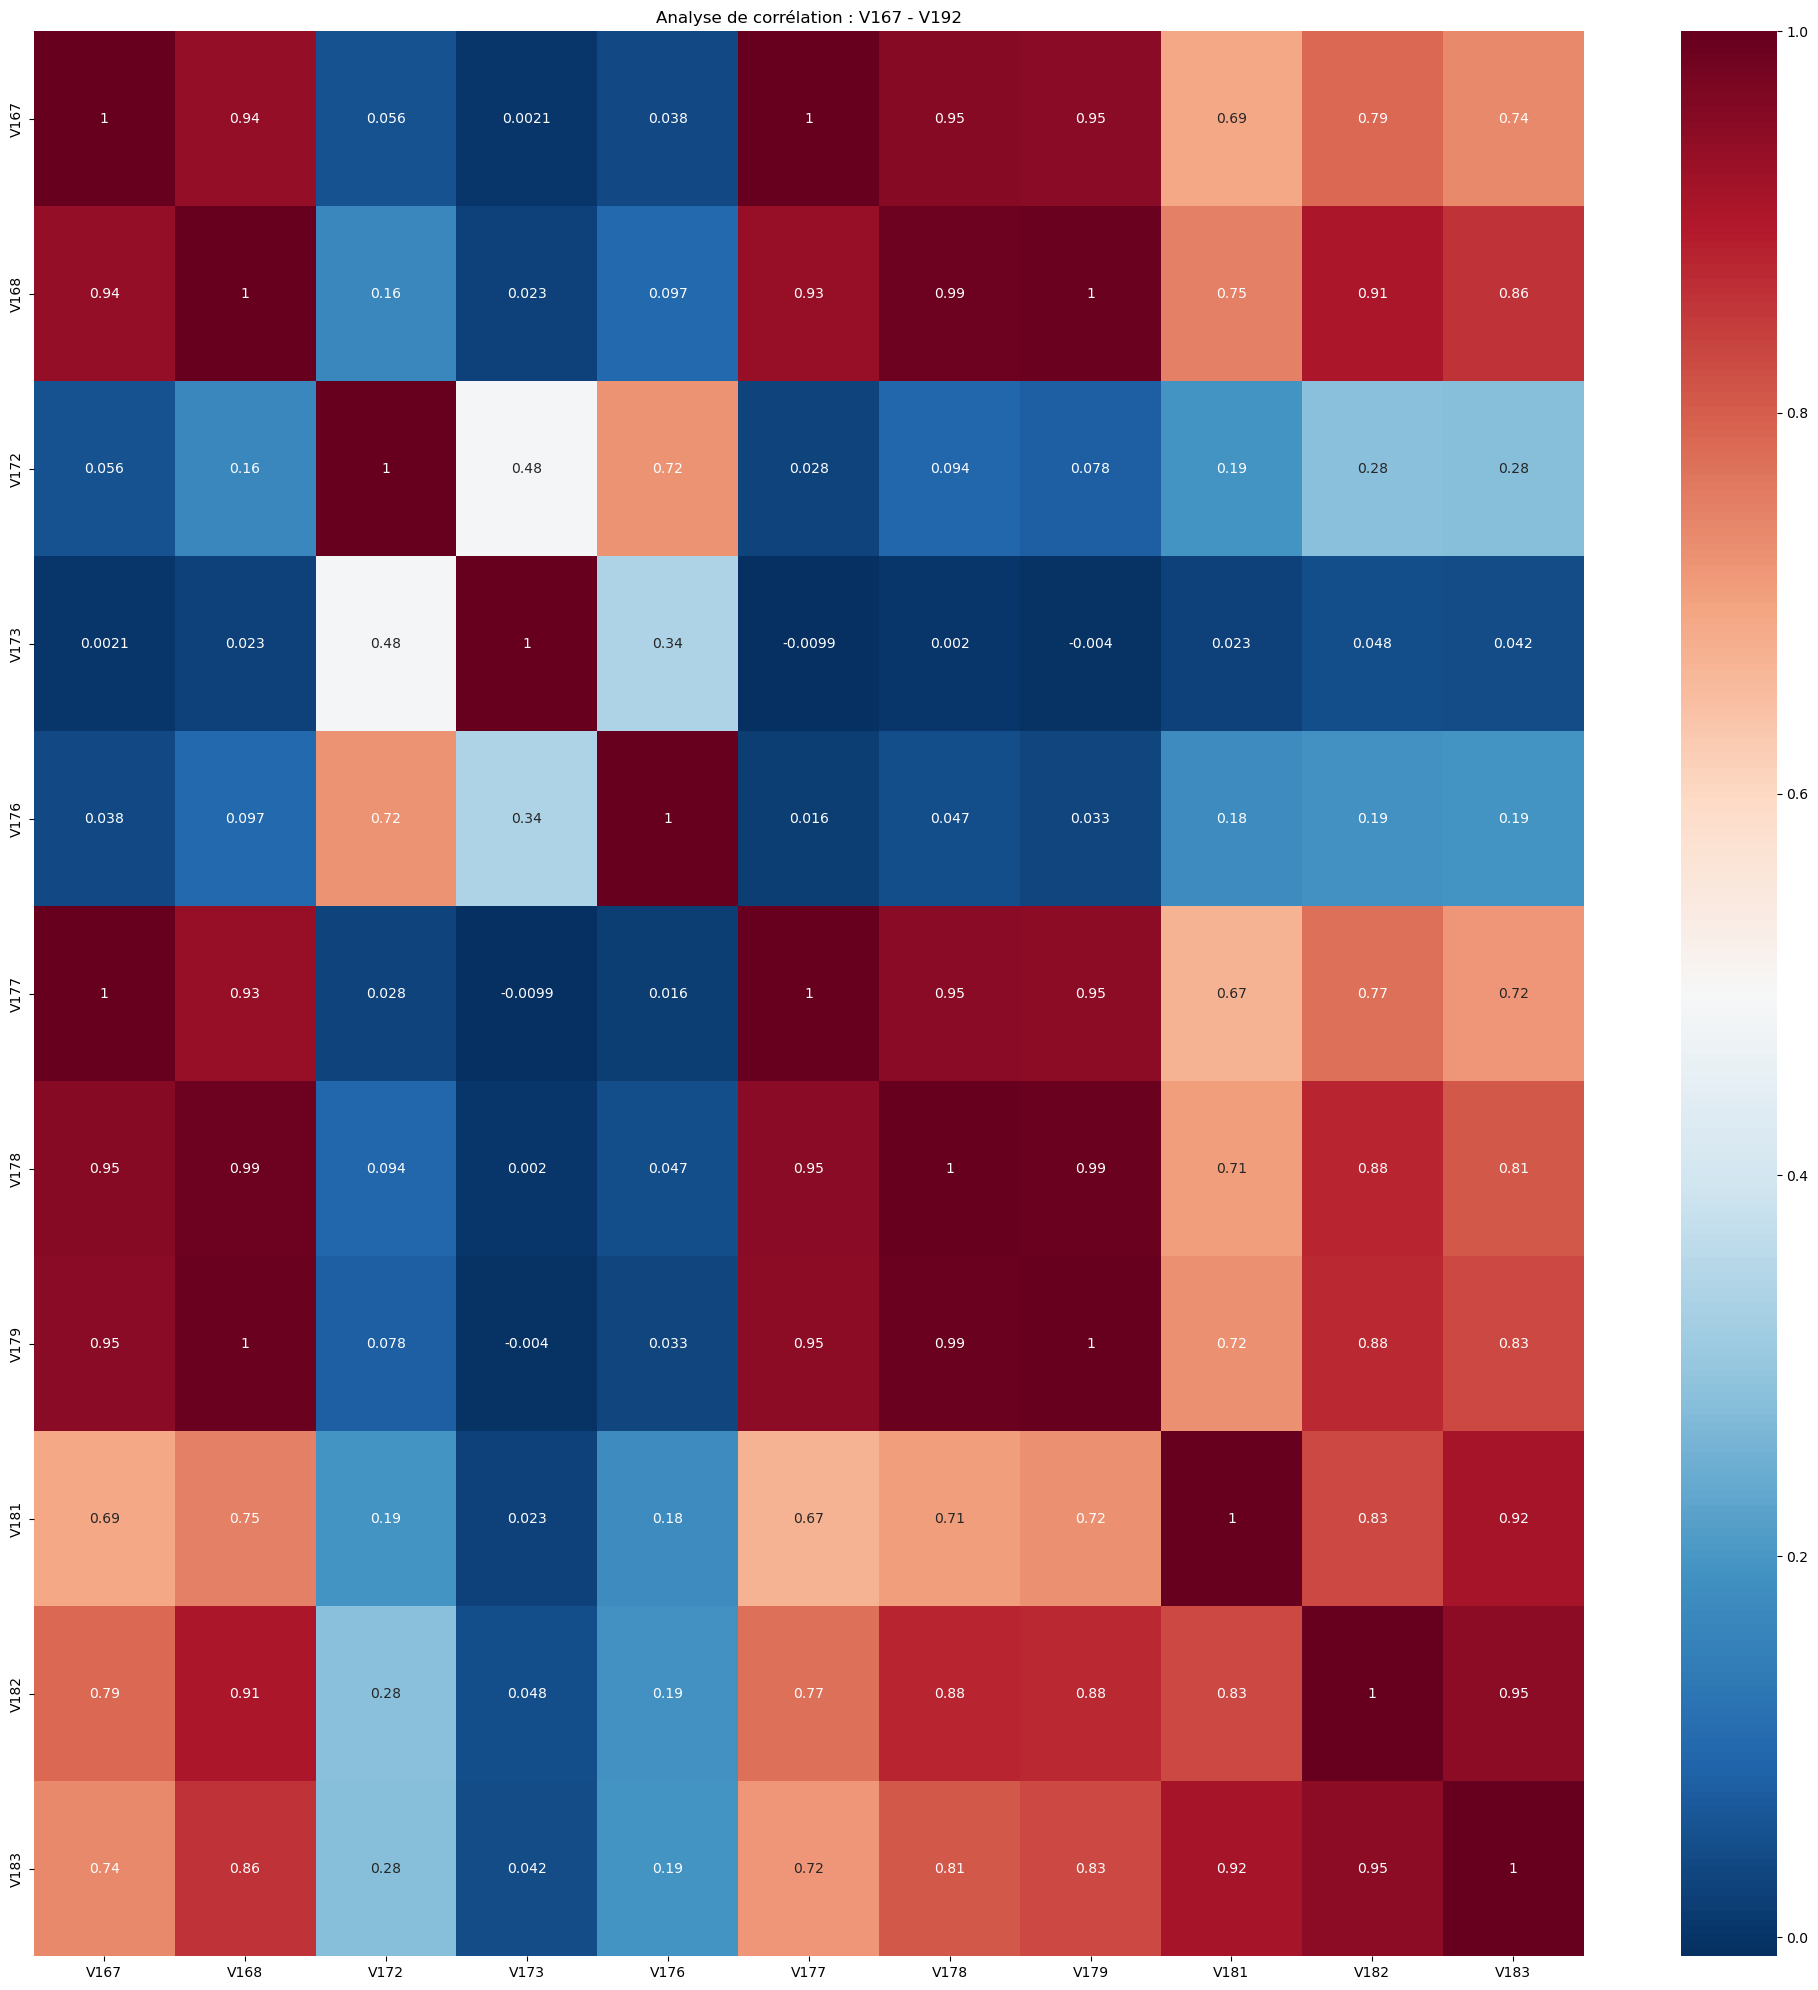

In [200]:
cols = ['V167', 'V168','V172','V173','V176','V177','V178','V179','V181','V182','V183']
coorelation_analysis(cols, title="Analyse de corrélation : V167 - V192", size=(25, 25))

In [201]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v167_to_v192 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v167_to_v192)
cols_reduced_v167_to_v192

['V178', 'V172', 'V173', 'V176']

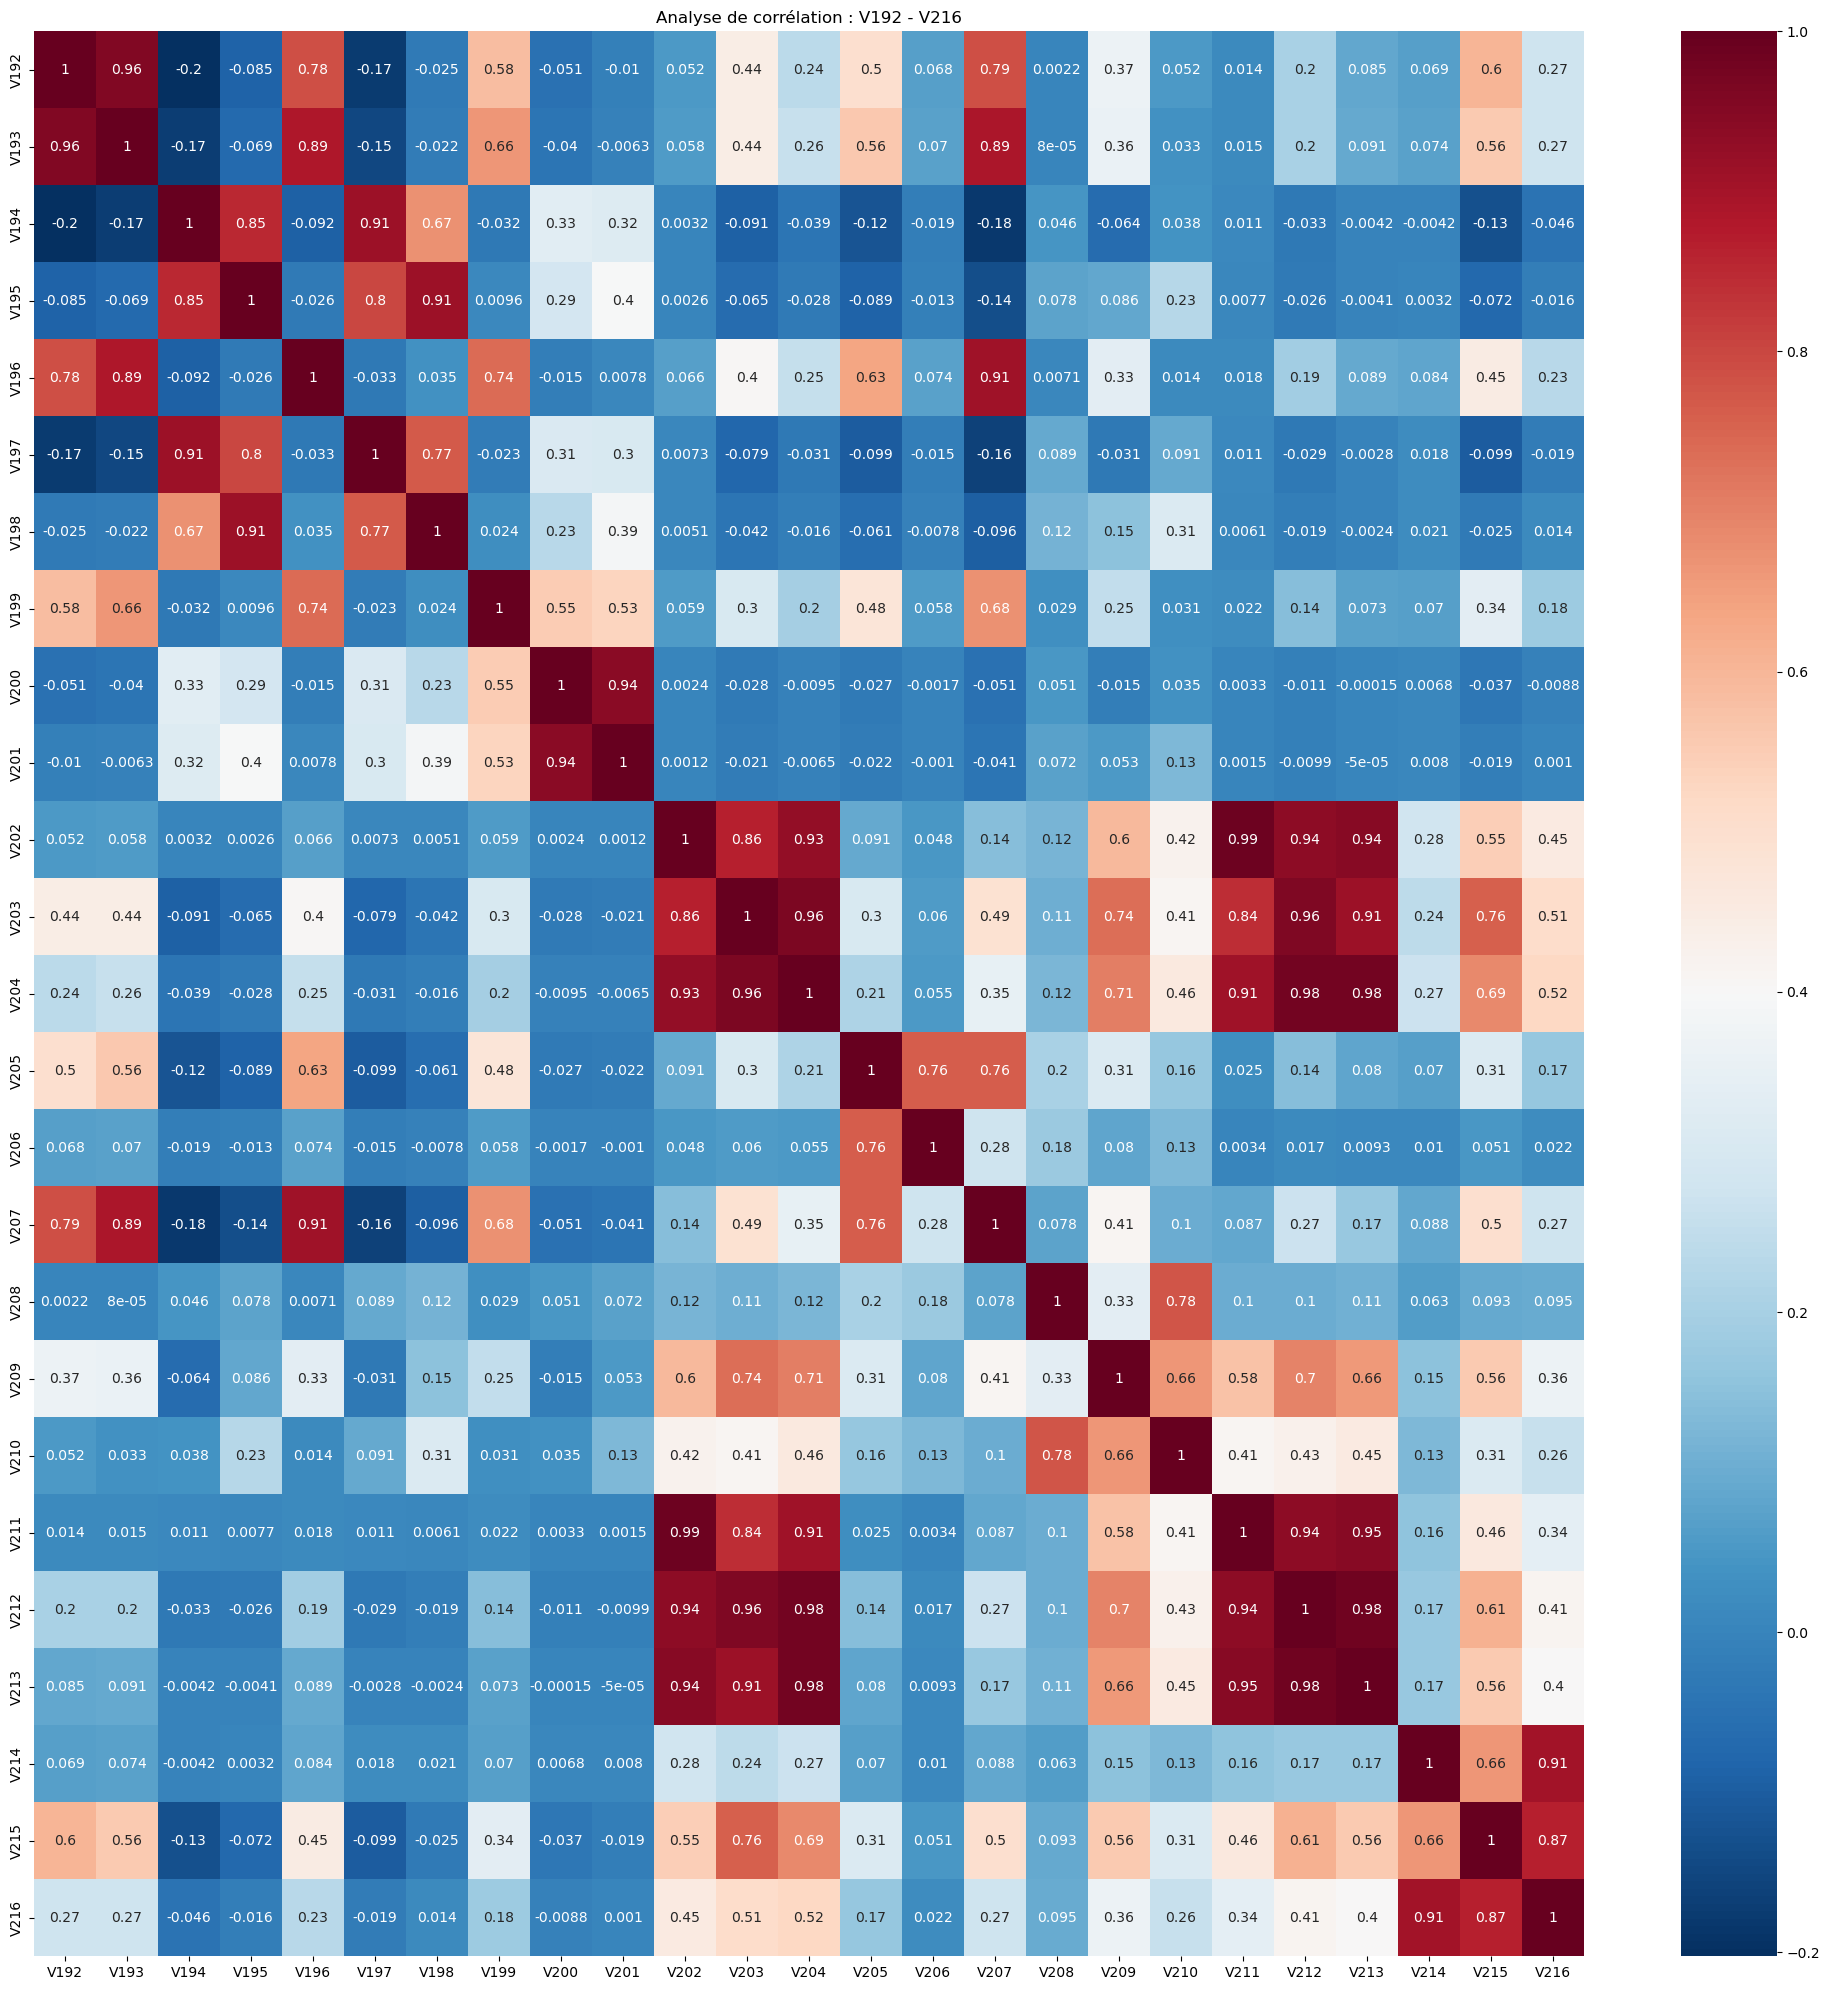

In [202]:
cols = [f"V{i}" for i in range(192, 217)]
correlation_analysis(cols, title="Analyse de corrélation : V192 - V216", size=(25, 25))

In [203]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v192_to_v217 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v192_to_v217)
cols_reduced_v192_to_v217

['V207', 'V198', 'V199', 'V201', 'V203', 'V210', 'V209']

## Groupe10 [V217 - V278]

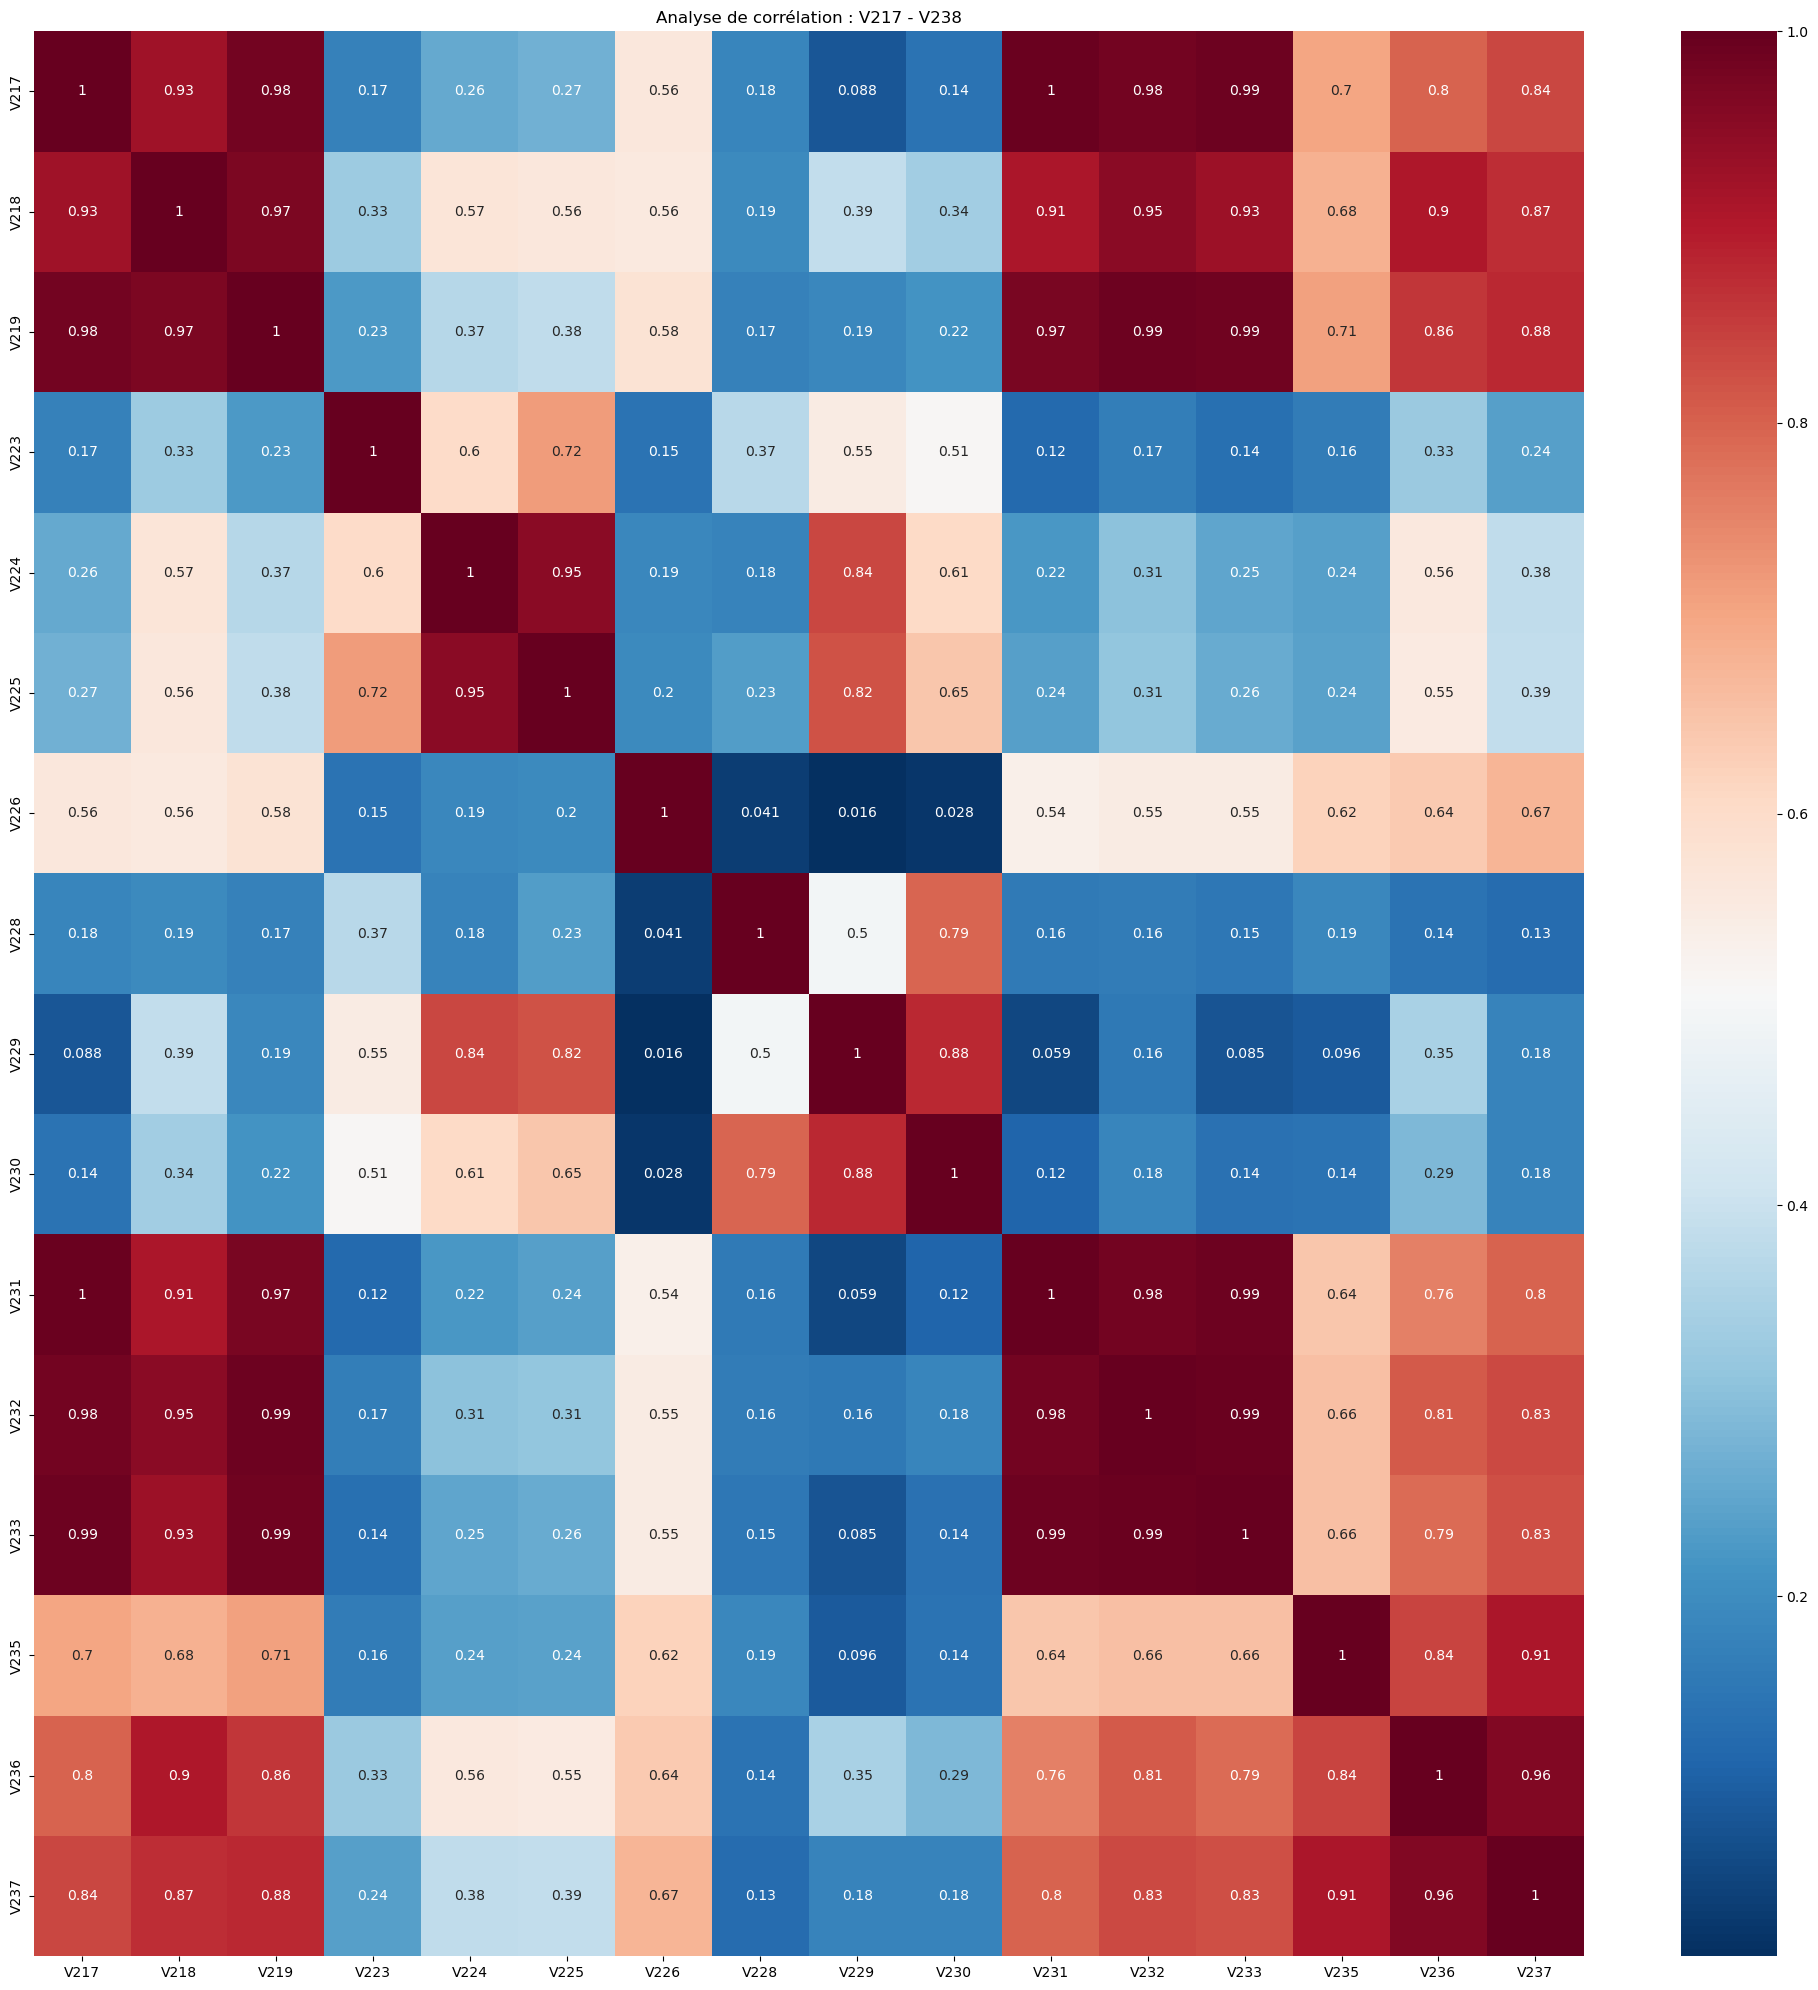

In [204]:
cols = ['V217','V218','V219','V231','V232','V233','V236','V237','V223','V224','V225','V226','V228','V229','V230','V235']
coorelation_analysis(cols,title="Analyse de corrélation : V217 - V238", size=(25, 25))

In [205]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v217_to_v238 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v217_to_v238)
cols_reduced_v217_to_v238

['V218', 'V223', 'V229', 'V226']

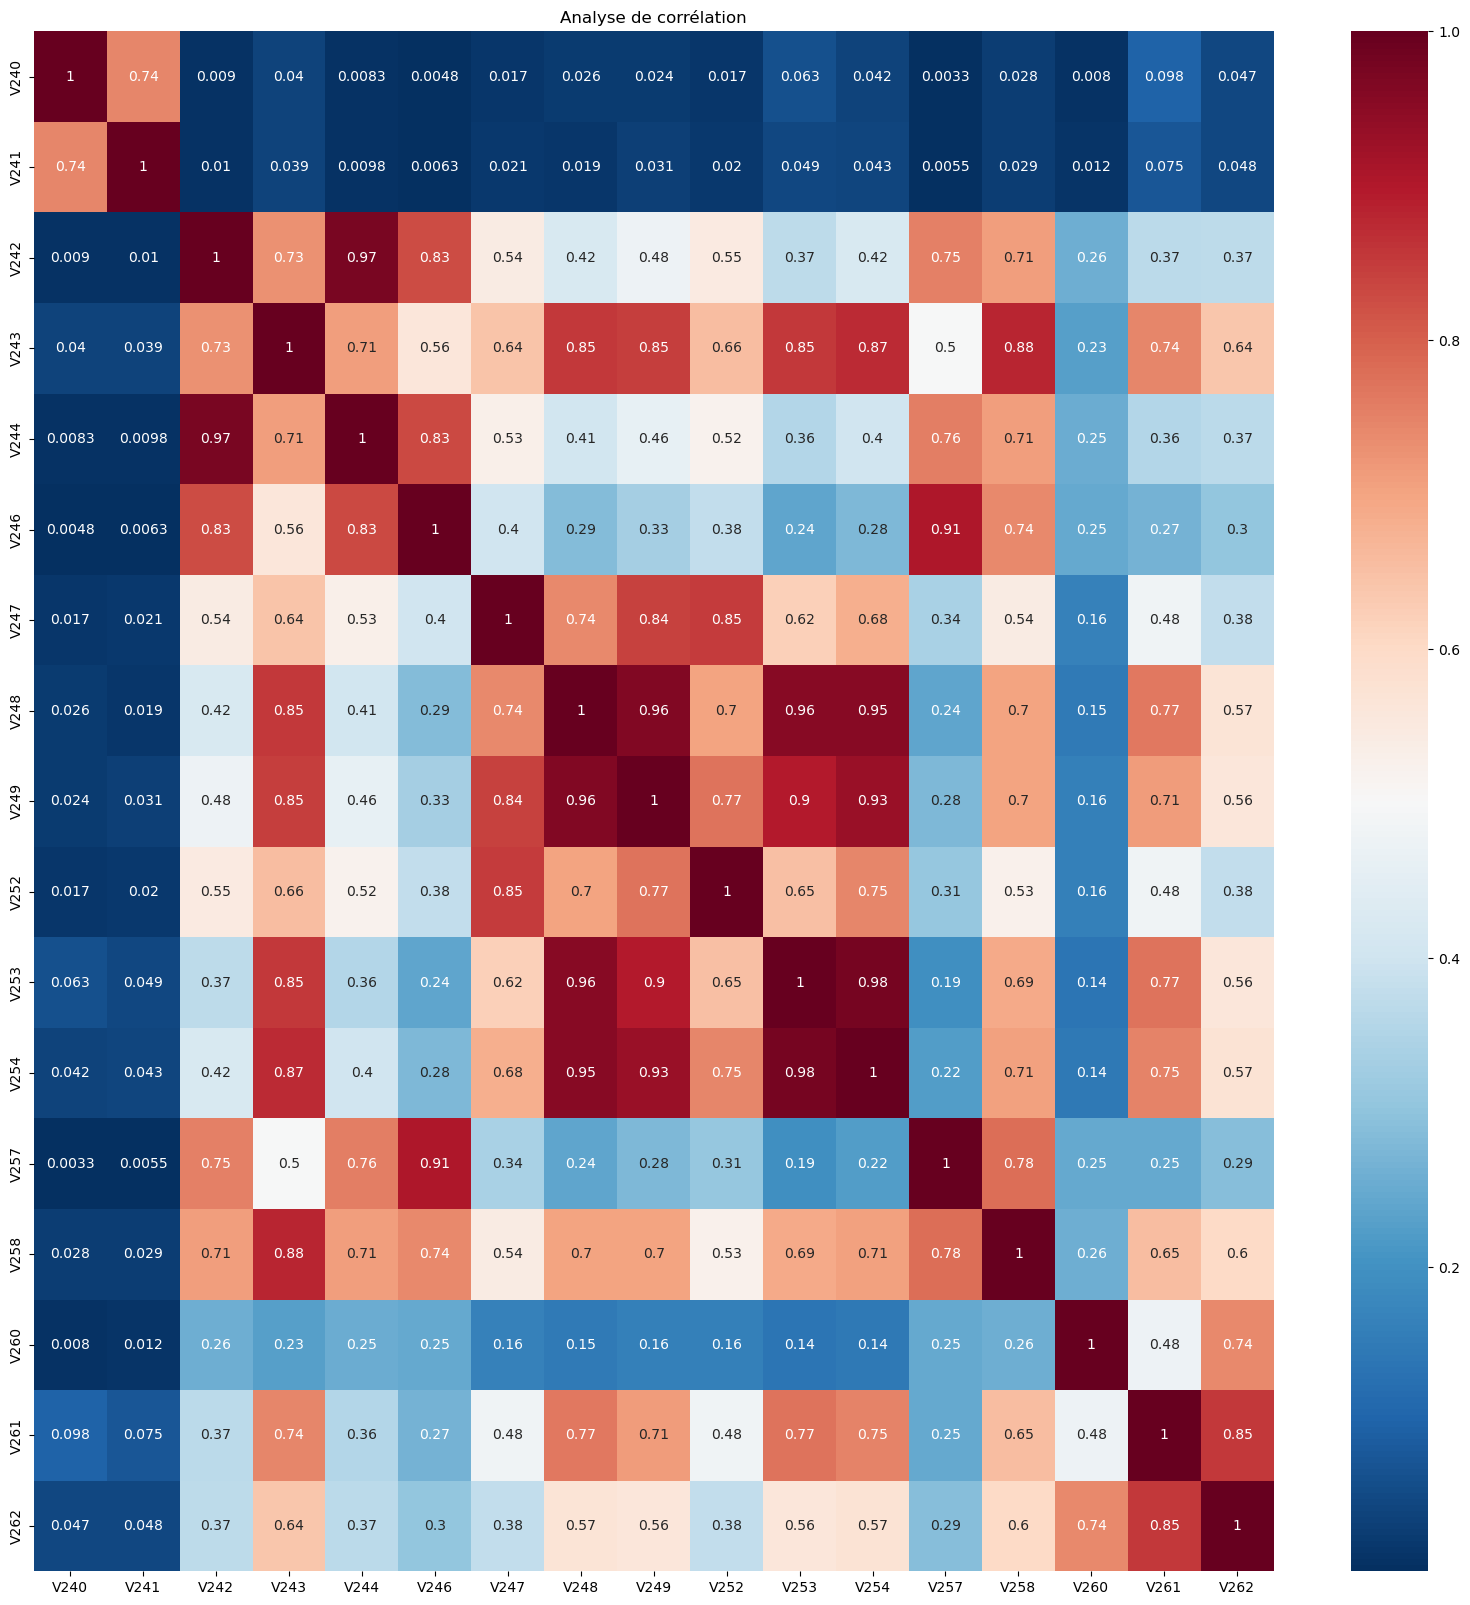

In [206]:
cols = ['V240','V241','V242','V243','V244','V258','V246','V257','V247','V248','V249','V253','V254','V252','V260','V261','V262']

coorelation_analysis(cols,title='Analyse de corrélation',size=(20,20))

In [207]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v238_to_v258 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v238_to_v258)
cols_reduced_v238_to_v258

['V240', 'V241', 'V258', 'V260']

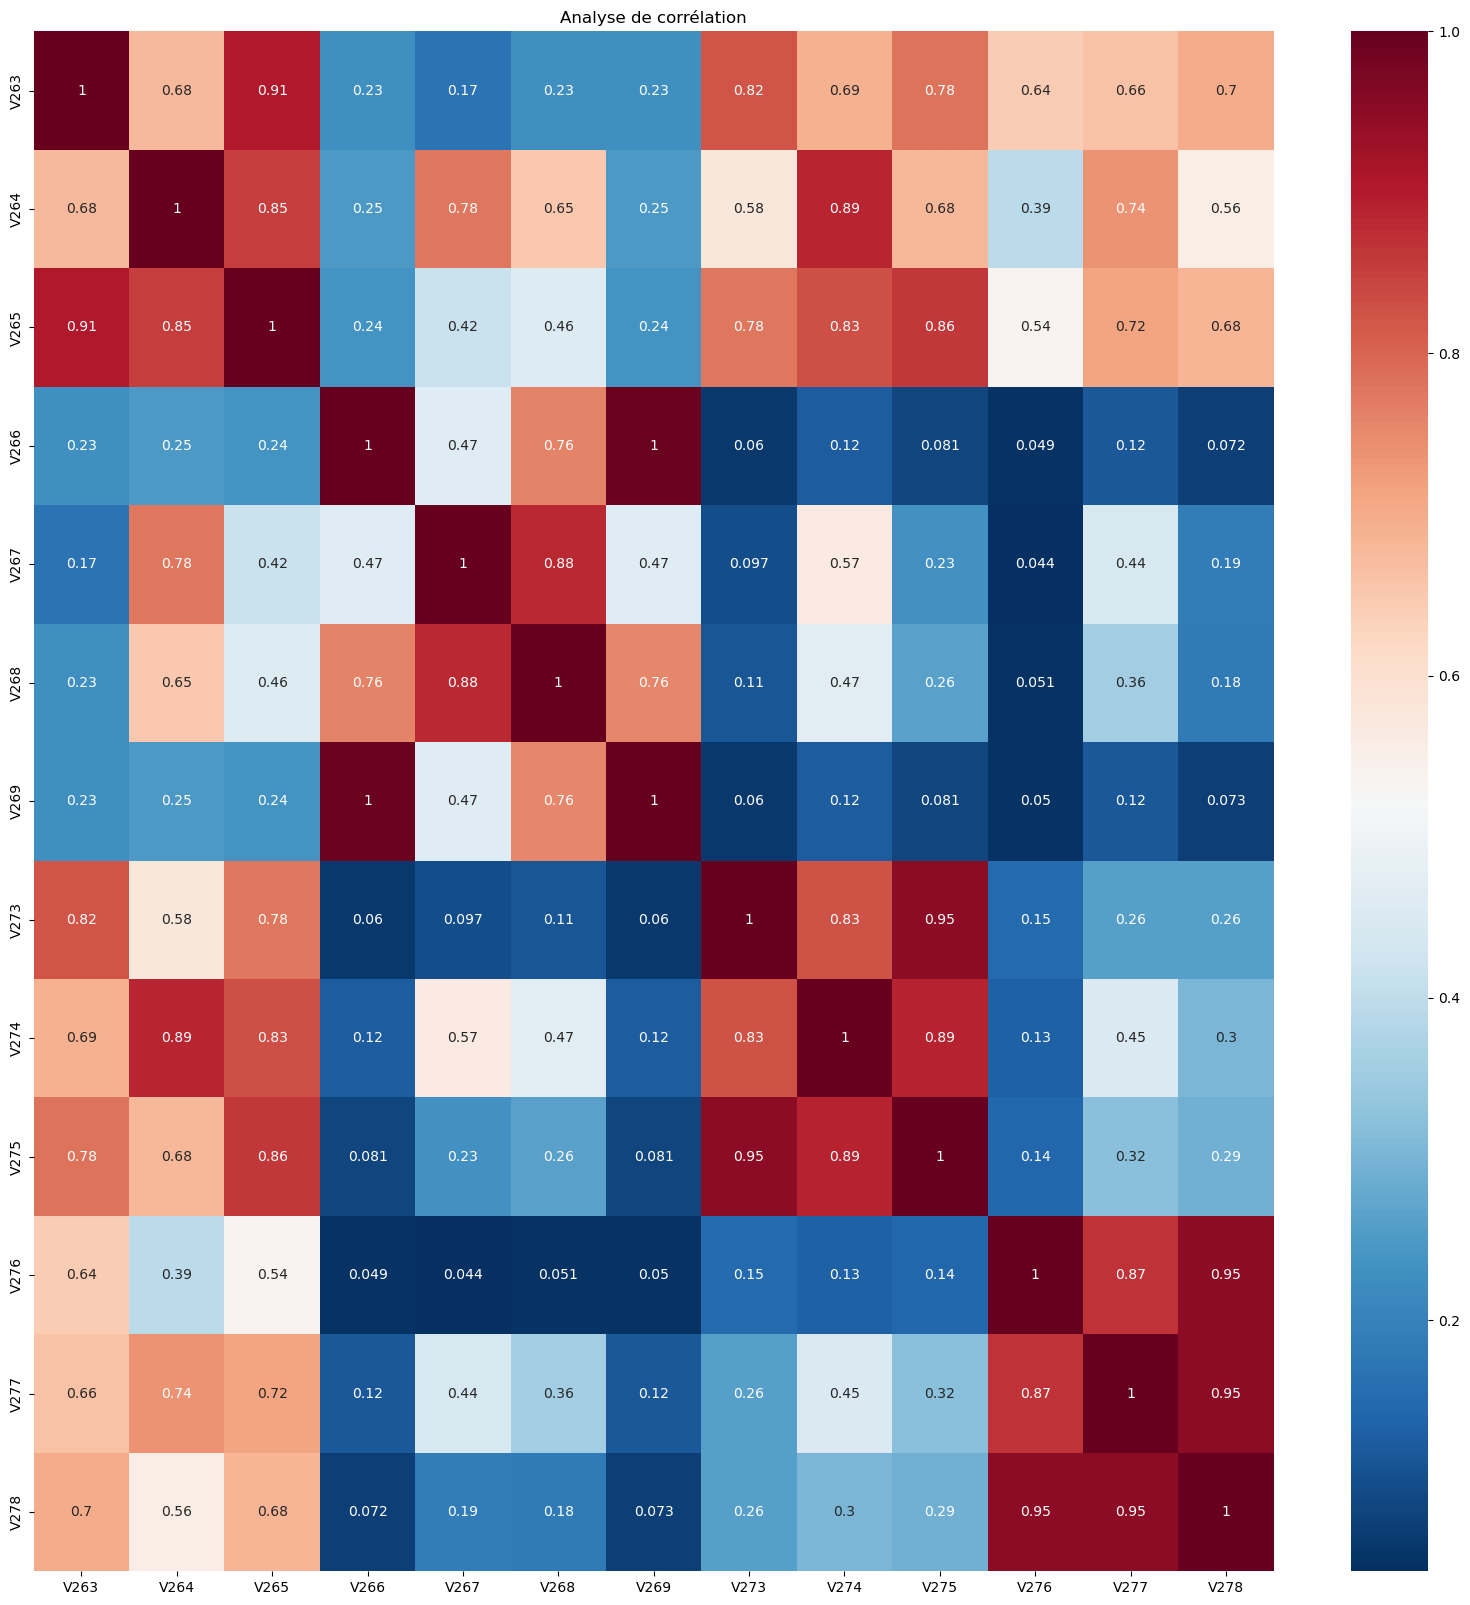

In [208]:
cols =  ['V263','V265','V264','V266','V269','V267','V268','V273','V274','V275','V276','V277','V278']

coorelation_analysis(cols,title='Analyse de corrélation',size=(20,20))

In [209]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v258_to_v278 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v258_to_v278)
cols_reduced_v258_to_v278

['V264', 'V277']

## Groupe11 [V220 - V272]

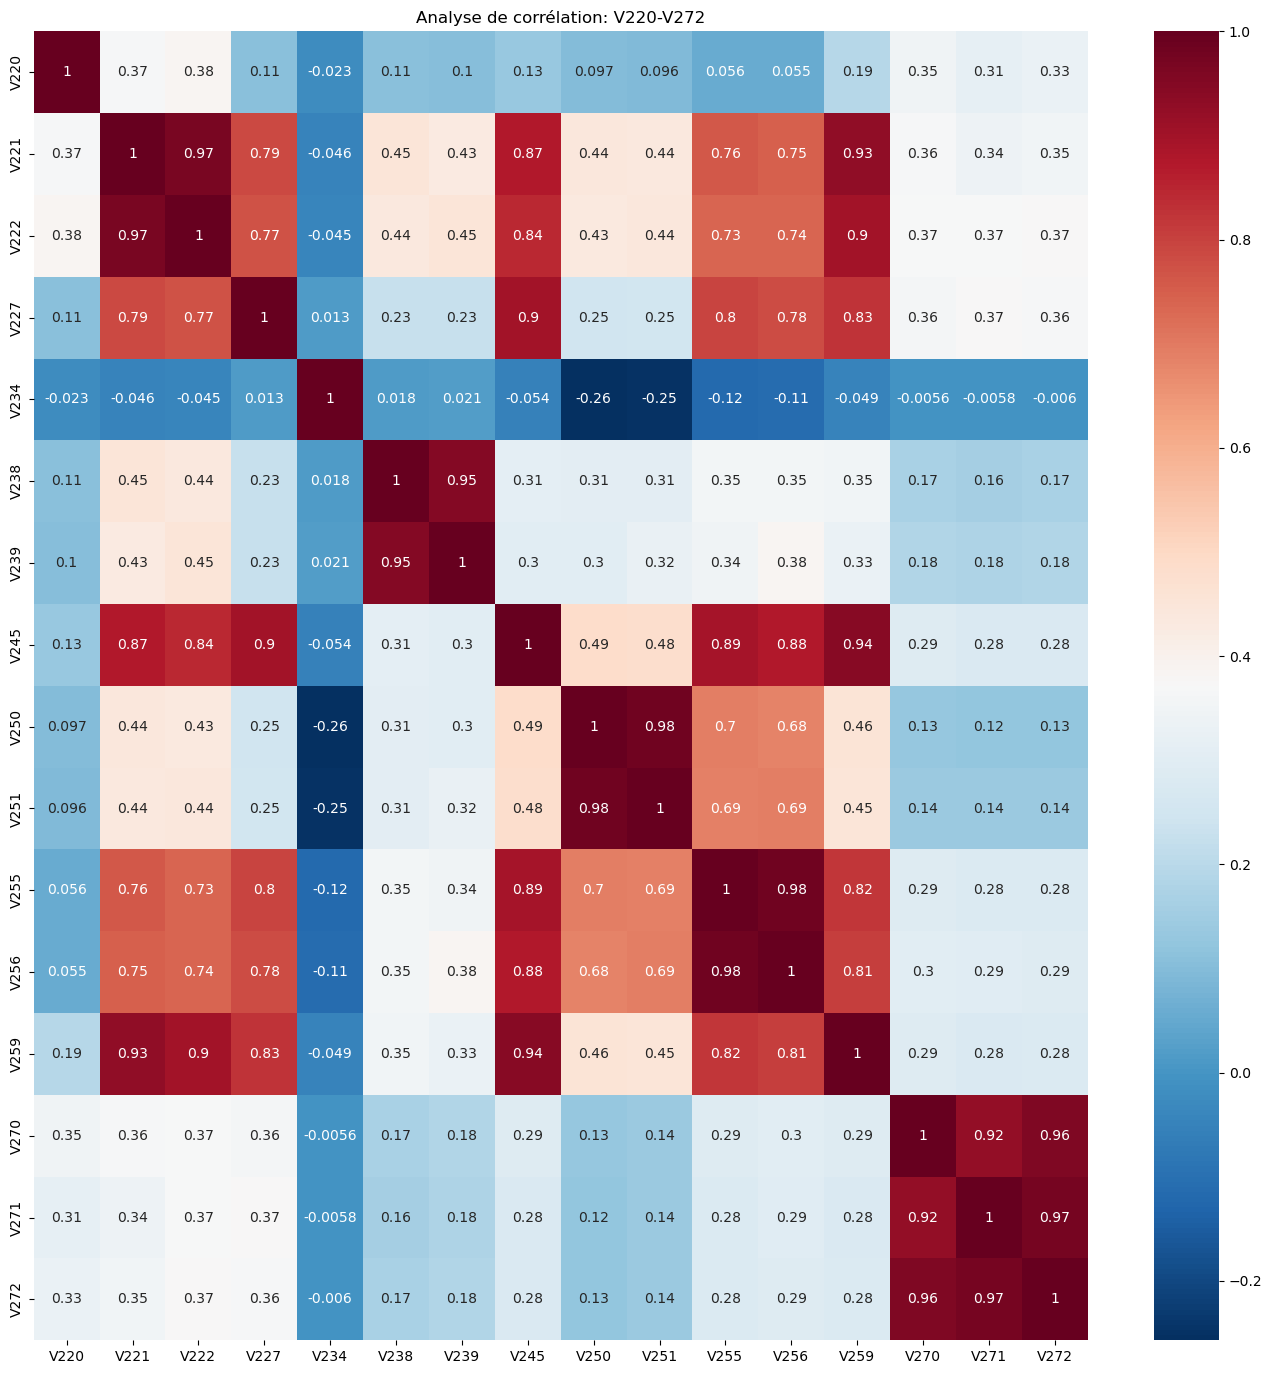

In [210]:
cols = ['V245', 'V271', 'V234', 'V222', 'V238', 'V239', 'V227', 'V250', 
 'V272', 'V270', 'V251', 'V220', 'V255', 'V256', 'V259', 'V221']

coorelation_analysis(cols,title='Analyse de corrélation: V220-V272',size=(17,17))


In [211]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v279_to_v300 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v279_to_v300)
cols_reduced_v279_to_v300

['V220', 'V221', 'V234', 'V238', 'V250', 'V271']

## Groupe12 [V279 - V321]

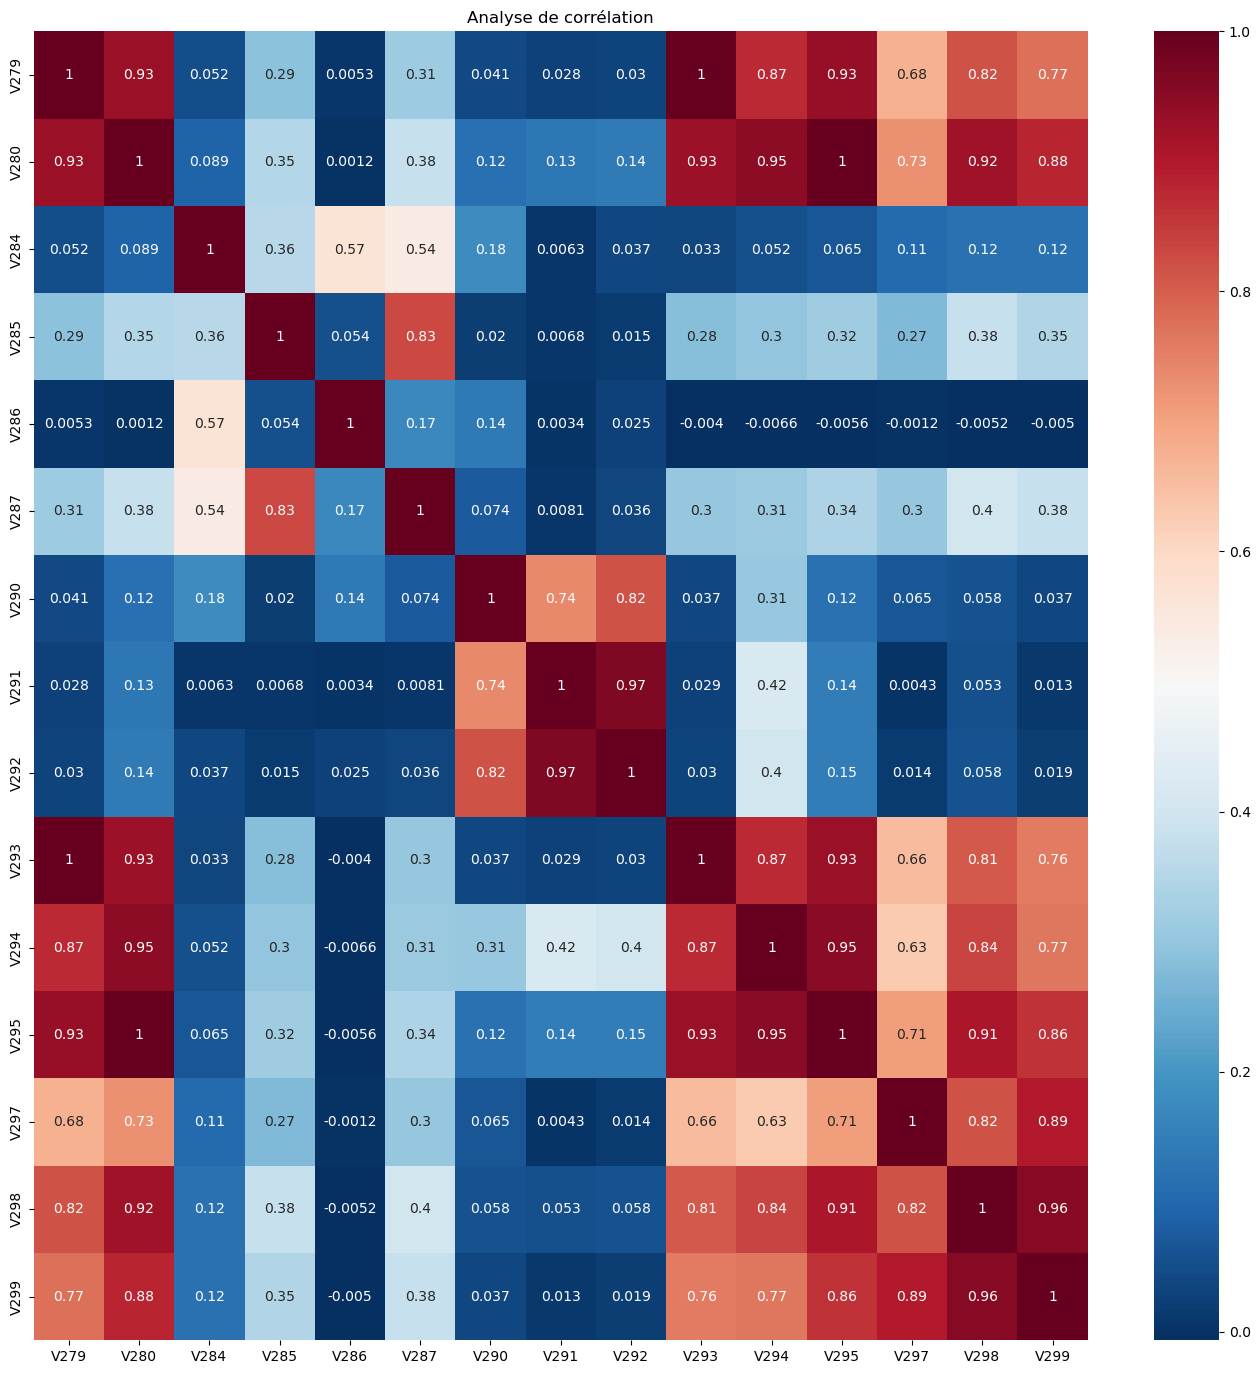

In [212]:
cols = ['V279','V280','V293','V294','V295','V298','V299','V284','V285','V287','V286','V290','V291','V292','V297']

coorelation_analysis(cols,title='Analyse de corrélation',size=(17,17))

In [213]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v279_to_v299 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v279_to_v299)
cols_reduced_v279_to_v299

['V294', 'V284', 'V285', 'V286', 'V291']

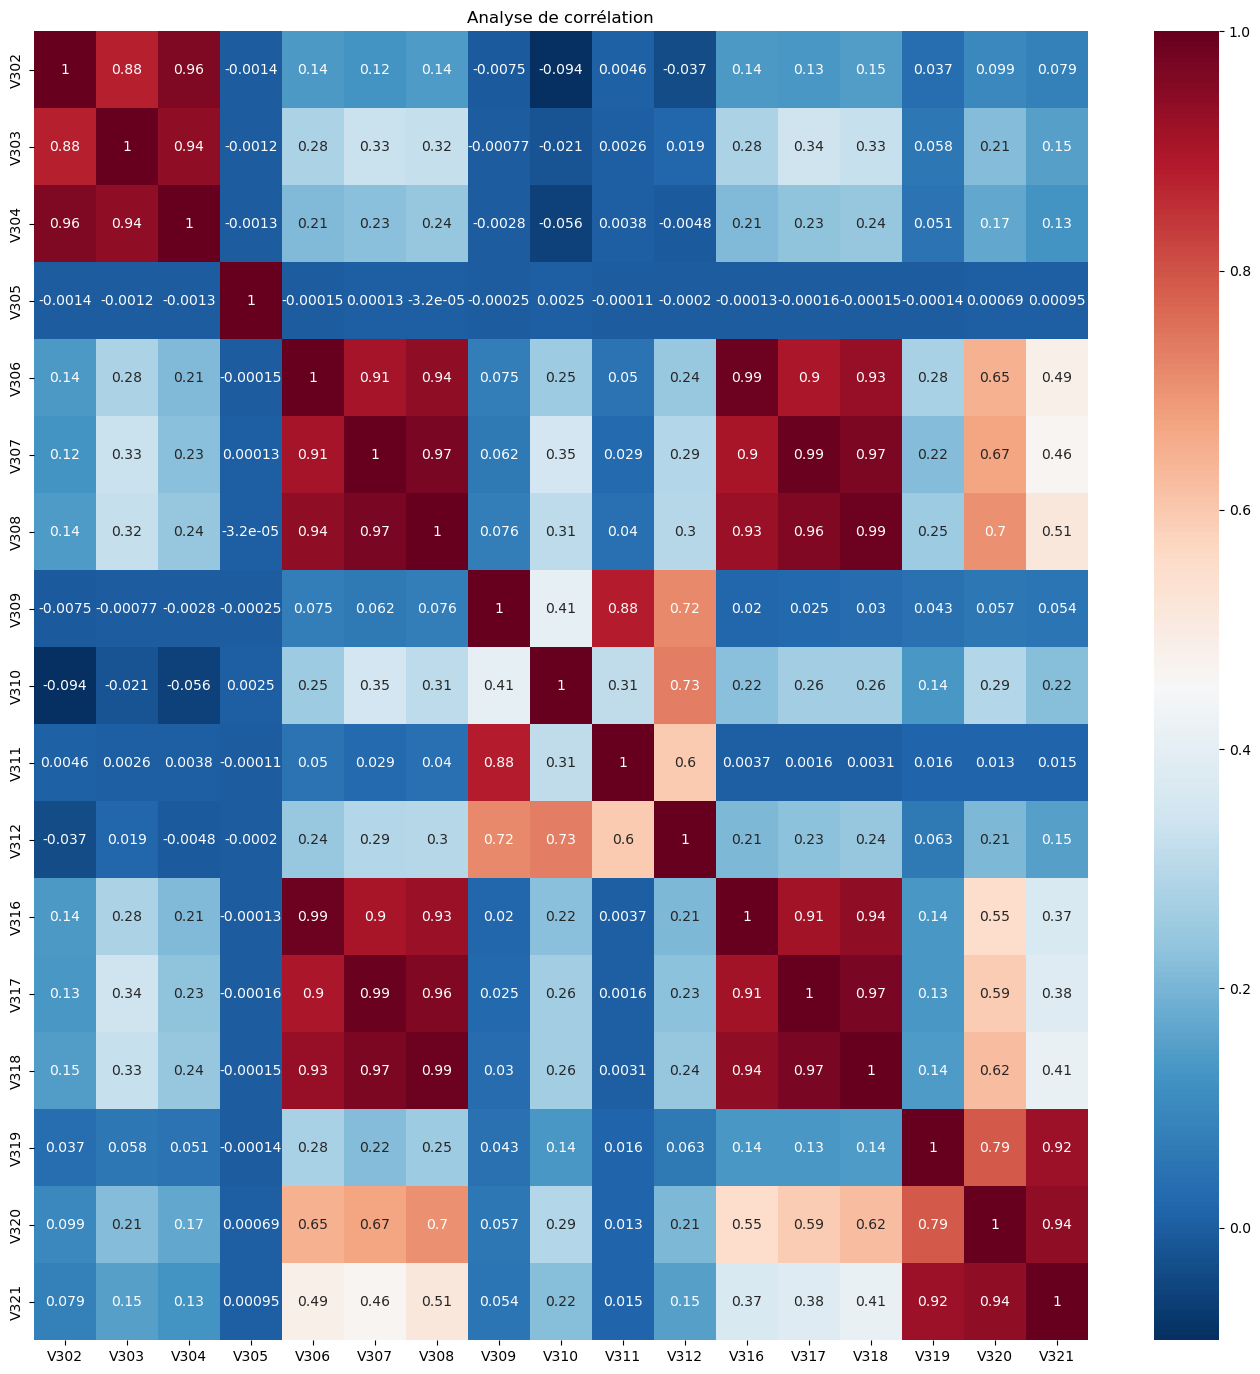

In [214]:
cols = ['V302','V303','V304','V305','V306','V307','V308','V316','V317','V318','V309','V311','V310','V312','V319','V320','V321']

correlation_analysis(cols,title='Analyse de corrélation',size=(17,17))

In [215]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v300_to_v321 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v300_to_v321)
cols_reduced_v300_to_v321

['V303', 'V305', 'V307', 'V309', 'V310', 'V312', 'V320']

## Groupe13 [V281 - V313]

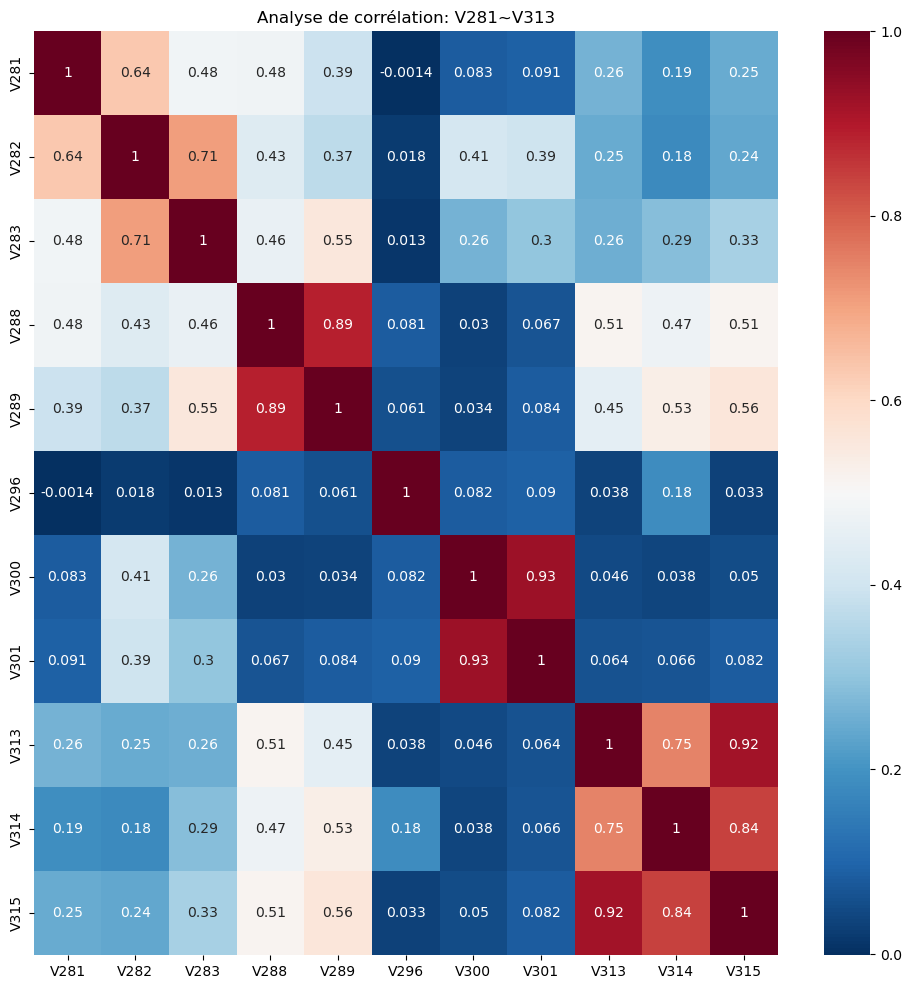

In [216]:
cols = ['V296', 'V289', 'V288', 'V283', 'V282', 'V281', 'V300', 'V301', 'V313', 'V314', 'V315']

correlation_analysis(cols,title='Analyse de corrélation: V281~V313',size=(12,12))


In [217]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v281_to_v313 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v281_to_v313)
cols_reduced_v281_to_v313

['V281', 'V282', 'V283', 'V289', 'V296', 'V301', 'V314']

## Groupe14 [V322 - V339]

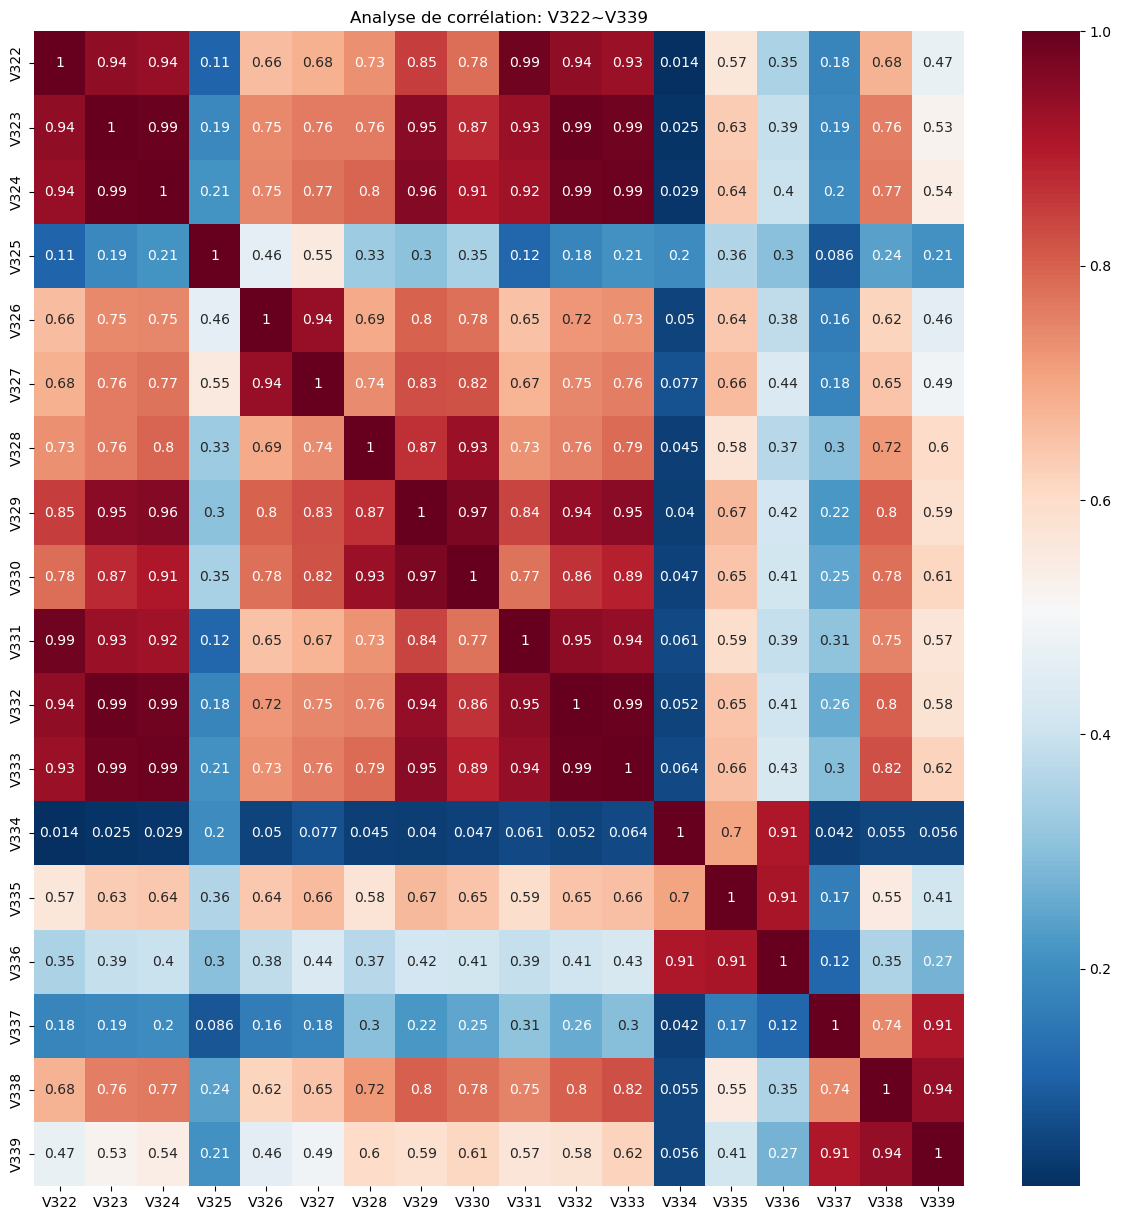

In [218]:
cols = ['V337', 'V333', 'V336', 'V335', 'V334', 'V338', 'V339', 'V324',
 'V332', 'V325', 'V330', 'V329', 'V328', 'V327', 'V326', 'V322', 'V323', 'V331']

correlation_analysis(cols,title='Analyse de corrélation: V322~V339',size=(15,15))


In [219]:
pairs = group_correlated_columns(df_train, cols)
cols_reduced_v322_to_v339 = reduce_groups(pairs)
reduced_cols.extend(cols_reduced_v322_to_v339)
cols_reduced_v322_to_v339

['V332', 'V325', 'V335']

In [225]:
print(reduced_cols)

['V1', 'V11', 'V3', 'V4', 'V6', 'V8', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V99', 'V96', 'V98', 'V107', 'V108', 'V109', 'V111', 'V114', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V131', 'V138', 'V139', 'V142', 'V147', 'V155', 'V162', 'V165', 'V160', 'V166', 'V178', 'V172', 'V173', 'V176', 'V207', 'V198', 'V199', 'V201', 'V203', 'V210', 'V209', 'V218', 'V223', 'V229', 'V226', 'V240', 'V241', 'V258', 'V260', 'V264', 'V277', 'V220', 'V221', 'V234', 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291', 'V303', 'V305', 'V307', 'V309', 'V310', 'V312', 'V320', 'V281', 'V282', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335']
